# Import

In [27]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

# 08/02/2023

## Mismatch dispersion plot

### SantaLucia Mismatch

#### Prepare data from literature

In [2]:
sl_mm = pd.read_csv('./data/literature/SantaLucia_single_mismatch.csv', index_col=0)
sl_mm['isWC'] = sl_mm.dG_37.apply(lambda x: x == 'WC')
sl_wc = pd.read_csv('./data/literature/SantaLucia_full.tsv', sep='\t', index_col=0)

In [5]:
def add_wc(row):
    if row.dG_37 == 'WC':
        return float(sl_wc.loc[row.name, 'dG_37'])
    else:
        return float(row.dG_37)
    
sl_mm['dG_37'] = sl_mm.apply(add_wc, axis=1)

### Compare Mismatches

In [123]:
arr = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)

In [124]:
def replace_at_index(s:str, newstring:str, idx:int):
    return s[:idx] + newstring + s[idx + 1:]
  
def find_mm_parent(seq, struct, arr):
    def get_parent_candidates(seq, struct):
        if '.(.' in struct:
            return None, None
        
        bp_dict = dict(A='T', C='G', T='A', G='C')
        idxmm = (('('+struct).find('((.(') + 1, (struct+')').find(').))') + 1)
        if idxmm[0] == 0 or idxmm[1] == 1:
            return None, None
        else:
            parent1 = replace_at_index(seq, bp_dict[seq[idxmm[0]]], idxmm[1])
            mm1 = bp_dict[seq[idxmm[0]]] + '>' + seq[idxmm[1]]
            parent2 = replace_at_index(seq, bp_dict[seq[idxmm[1]]], idxmm[0])
            mm2 = bp_dict[seq[idxmm[1]]] + '>' + seq[idxmm[0]]
            # context = seq[idxmm[0]-1:idxmm[0]] + '.' + seq[idxmm[0]+1: idxmm[0]+2]
            context = seq[idxmm[0]-1:idxmm[0]+2] + seq[idxmm[1]-1:idxmm[1]+2]
            return {parent1: mm1, parent2: mm2}, context
        
    parent_candidates, context = get_parent_candidates(seq, struct)
    
    if parent_candidates is None:
        return np.nan
    
    idx_parent = []
    mm = []
    for candidate in parent_candidates:
        try:
            idx_parent.append(arr.RefSeq.tolist().index(candidate))
            mm.append(parent_candidates[candidate])
        except:
            continue
            
    if len(idx_parent) == 0:
        return np.nan
    else:
        return (arr.iloc[idx_parent].index.tolist(), mm, context)

In [125]:
df = arr.query("Series == 'External' | Series == 'MisMatches'")#.iloc[-1920:]
df['parent'] = df.apply(lambda row: find_mm_parent(row.RefSeq, row.TargetStruct, arr), axis=1)
df.dropna(subset=['parent'], inplace=True)

In [126]:
df['parent1'] = df.parent.apply(lambda x: x[0][0])
df['parent2'] = df.parent.apply(lambda x: x[0][-1] if len(x[0])==2 else None)
df['mismatch1'] = df.parent.apply(lambda x: x[1][0])
df['mismatch2'] = df.parent.apply(lambda x: x[1][-1] if len(x[1])==2 else None)
df['context'] = df.parent.apply(lambda x: x[2])

In [127]:
# massage into long form

cols = ['dG_37', 'dG_37_se', 'context']
df_new = pd.DataFrame(index=np.arange(2*len(df)), columns=['SEQID', 'parent', 'mismatch'] + cols)

i = 0
for seqid in df.index:
    for n in [1,2]:
        if df.loc[seqid, 'parent'+str(n)] is not None:
            row = {key:df.loc[seqid, key] for key in cols}
            row['SEQID'] = seqid
            row['parent'] = df.loc[seqid, 'parent'+str(n)]
            row['mismatch'] = df.loc[seqid, 'mismatch'+str(n)]
            df_new.iloc[i,:] = row
            i += 1
            
df_new.dropna(inplace=True)

In [144]:
df = df_new

df = df.set_index('parent').join(arr[['dG_37', 'dG_37_se']], rsuffix='_parent').reset_index()

In [145]:
def get_santalucia_mm_ddG(row):
    def unmutate(nt):
        return nt.replace(mismatch[2], mismatch[0])
        
    context = row['context']
    mismatch = row['mismatch']
    
    nn1 = context[0] + context[1] + '_' + context[4] + context[5]
    nn2 = context[3] + context[4] + '_' + context[1] + context[2]
    dG_mm = sl_mm.loc[nn1, 'dG_37'] + sl_mm.loc[nn2, 'dG_37']
    
    wc_nn1 = nn1[0] + unmutate(nn1[1]) + '_' + unmutate(nn1[3]) + nn1[4]
    wc_nn2 = nn2[0] + unmutate(nn2[1]) + '_' + unmutate(nn2[3]) + nn2[4]
    dG_wc = sl_mm.loc[wc_nn1, 'dG_37'] + sl_mm.loc[wc_nn2, 'dG_37']
    
    return dG_mm - dG_wc

df['ddG_37_sl'] = df.apply(get_santalucia_mm_ddG, axis=1)
df['ddG_37'] = (df.dG_37 - df.dG_37_parent).astype(float)
df['ddG_37_se'] = (df.dG_37_se + df.dG_37_se_parent).astype(float)

In [157]:
df['flank'] = df.context.apply(lambda x: x[0]+x[-1]+'x'+x[2:4])

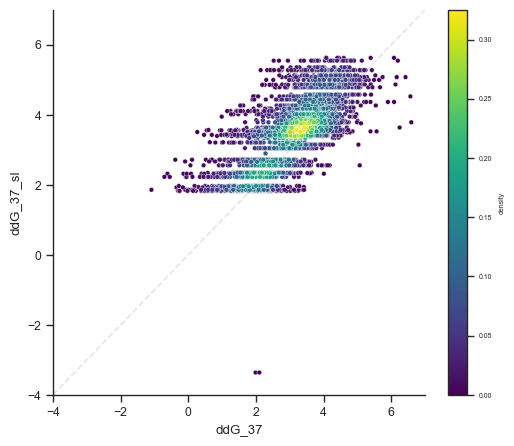

In [143]:
plotting.plot_colored_scatter_comparison(data=df, x='ddG_37', y='ddG_37_sl', 
                                         lim = (-4, 7), color_by_density=True, palette='viridis')

(array([479., 564., 464., 248., 830., 264., 545., 266., 395., 158.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

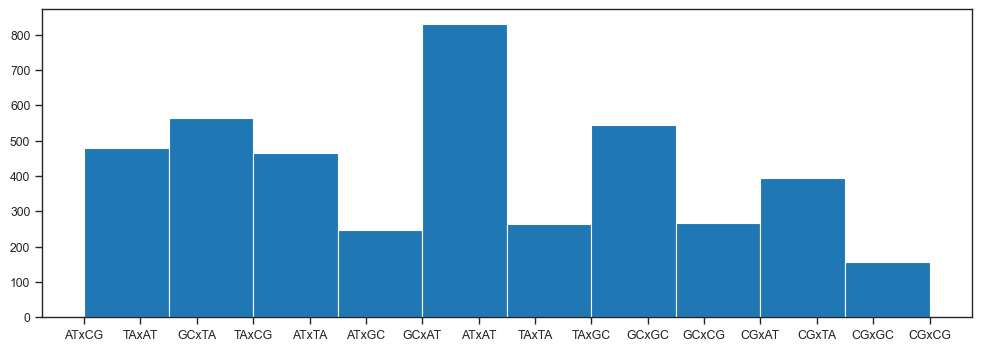

In [166]:
plt.figure(figsize=(12,4))
plt.hist(df.flank)

(array([ 805.,    0.,    2.,    0.,    2.,    0., 1509.,    0., 1300.,
         595.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

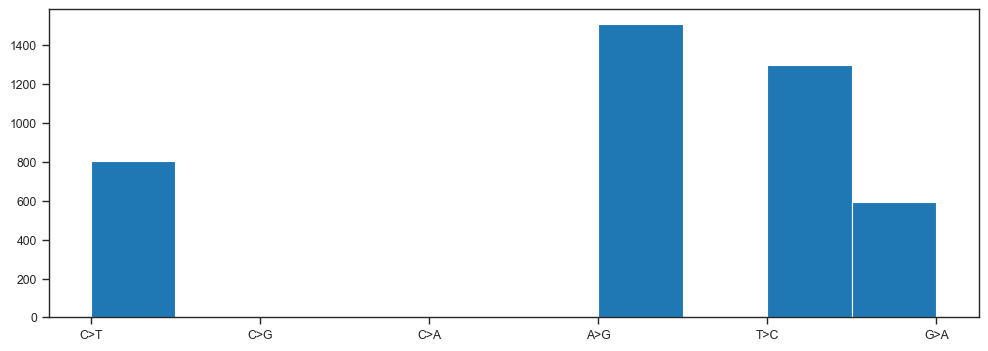

In [170]:
plt.figure(figsize=(12,4))
plt.hist(df.mismatch)

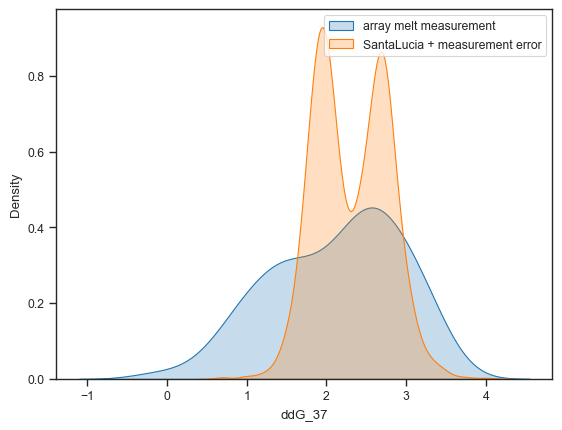

In [220]:
query = 'flank == "ATxGC" & mismatch == "A>G"'
# query = 'ddG_37_sl == 3.5'

tmp_df = df.query(query).reset_index()

n = 50 # num sample per datapoint
bootstrap = np.zeros((len(tmp_df), n))

for i,row in tmp_df.iterrows():
    mu = row.ddG_37_sl
    sigma = row.ddG_37_se
    bootstrap[i,:] = np.random.normal(mu, sigma, size=n)

kwargs = dict(fill=True)
sns.kdeplot(tmp_df.ddG_37, label='array melt measurement', **kwargs)
sns.kdeplot(bootstrap.flatten(), label='SantaLucia + measurement error', **kwargs)
plt.legend()
# plt.axvline(x=4)

# 08/03/2023

In [313]:
def get_explained_var(y, pred):
    var_dict = defaultdict()

    var_dict['total'] = np.var(y)
    var_dict['unexplained'] = np.var((y - pred))
    var_dict['explained'] =  var_dict['total'] - var_dict['unexplained']
    var_dict['explained_ratio'] = var_dict['explained'] / var_dict['total']
    var_dict['unexplained_ratio'] = var_dict['unexplained'] / var_dict['total']
    return var_dict

def bootstrap_ddG_37_sl(tmp_df):
    n = 1 # num sample per datapoint
    bootstrap = np.zeros((len(tmp_df), n))

    for i,row in tmp_df.iterrows():
        mu = row.ddG_37_sl
        sigma = row.ddG_37_se
        bootstrap[i,:] = np.random.normal(mu, sigma, size=n)
        
    return bootstrap.flatten()

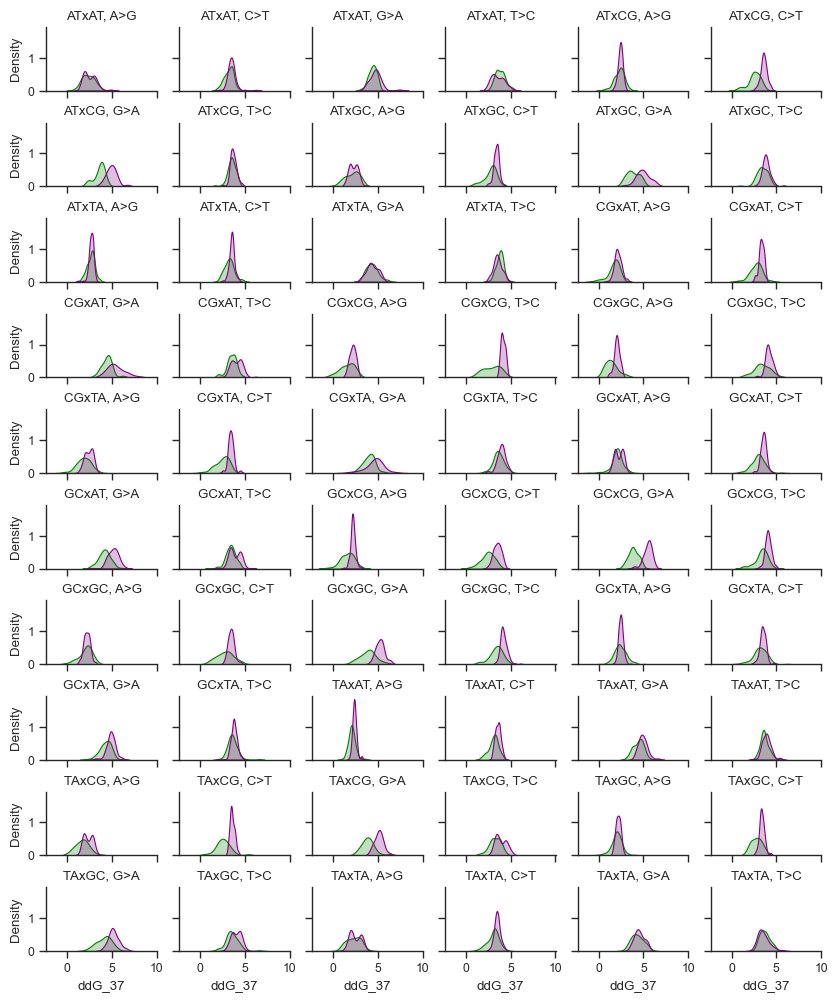

In [365]:
kwargs = dict(fill=True)
flanks, mismatches = np.unique(df.flank), np.unique(df.mismatch)

fig, ax = plt.subplots(10,6,figsize=(10,12), sharey=True, sharex=True)
ax = ax.flatten()

i = 0
ddG_df = pd.DataFrame(columns=['mm', 'ddG_37', 'dop'])

for f in flanks:
    for m in mismatches:
        query = f'flank == "{f}" & mismatch == "{m}"'
        tmp_df = df.query(query).reset_index()
        
        if len(tmp_df) > 10:
            ddG_37_sl_bt = bootstrap_ddG_37_sl(tmp_df)
            sl_bt_df = pd.DataFrame(dict(ddG_37=ddG_37_sl_bt, mm=f'{f}, {m}', dop='sl'))
            arr_ddG_df = pd.DataFrame(dict(ddG_37=tmp_df.ddG_37, mm=f'{f}, {m}', dop='arr'))
            ddG_df = pd.concat([ddG_df, arr_ddG_df, sl_bt_df])
            
            kwargs['ax'] = ax[i]
            ax[i].set_title(f'{f}, {m}')
            sns.kdeplot(tmp_df.ddG_37, label='array melt measurement', color='green', **kwargs)
            sns.kdeplot(ddG_37_sl_bt, label='SantaLucia + measurement error', color='purple', **kwargs)
            sns.despine()
            i += 1
        
# plt.legend()
plt.subplots_adjust(hspace=.5)

util.save_fig('./fig/Fig3/mismatch/mm_spread_hist.pdf')

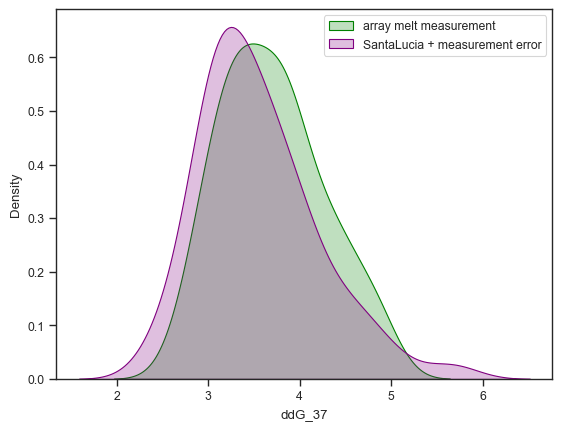

In [367]:
kwargs = dict(fill=True)
sns.kdeplot(tmp_df.ddG_37, label='array melt measurement', color='green', **kwargs)
sns.kdeplot(ddG_37_sl_bt, label='SantaLucia + measurement error', color='purple', **kwargs)
plt.legend()
util.save_fig('./fig/Fig3/mismatch/mm_spread_hist_legend.pdf')

<Axes: xlabel='ddG_37', ylabel='mm'>

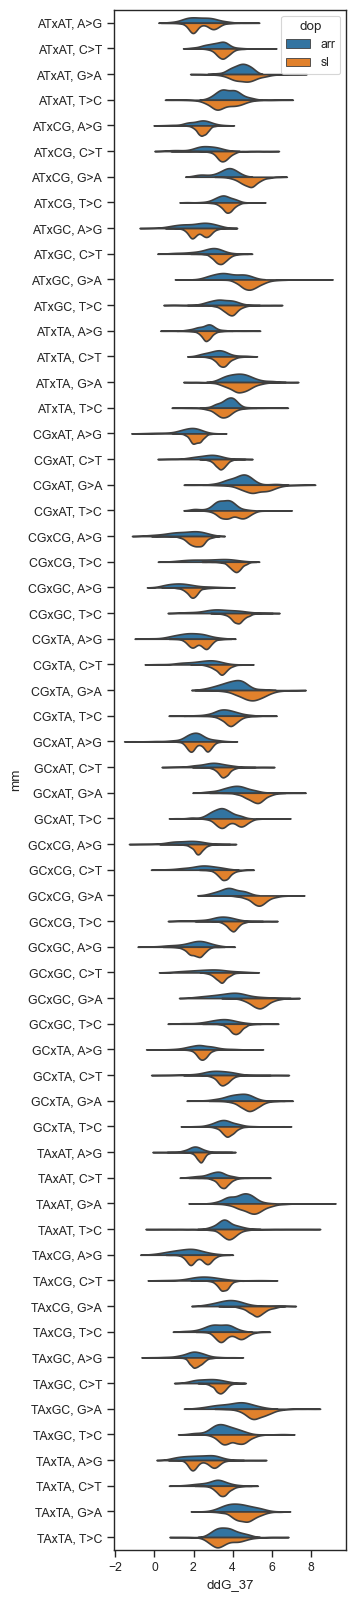

In [254]:
# same as the kdeplot
# not as easy to see
fig, ax = plt.subplots(figsize=(3,20))
sns.violinplot(data=ddG_df, y='mm', x='ddG_37', hue='dop', 
               inner=None, dodge=False, split=True, ax=ax)

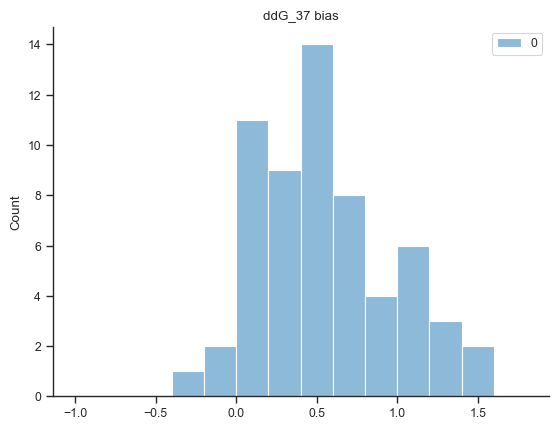

In [317]:
tmp_df = ddG_df.groupby(['mm','dop']).apply(np.mean)
bias = {mm: np.diff(tmp_df.loc[mm].values.flatten())[0] for mm in tmp_df.index.get_level_values(0)}

sns.histplot(bias.values(), bins=np.arange(-1,2,.2))
plt.title('ddG_37 bias')
sns.despine()

In [310]:
from sklearn.metrics import explained_variance_score

In [318]:
def unexplained_ratio(mm):
    flank, mismatch = mm.split(', ')
    tmp_df = df.query(f'flank == "{flank}" & mismatch == "{mismatch}"')
    return explained_variance_score(tmp_df.ddG_37, tmp_df.ddG_37_sl)
unexplained_ratio = {mm: unexplained_ratio(mm) for mm in np.unique(ddG_df.mm)}

<Axes: ylabel='Count'>

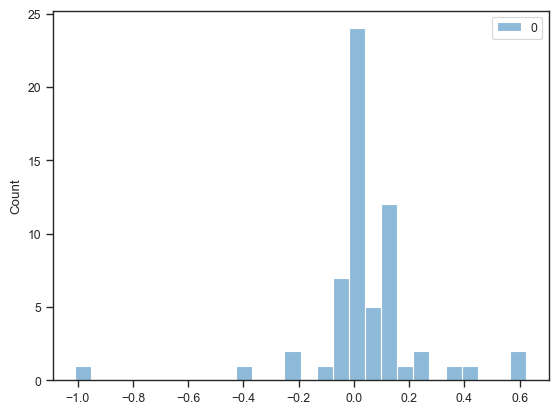

In [319]:
sns.histplot(unexplained_ratio.values())

(0.0, 1.0)

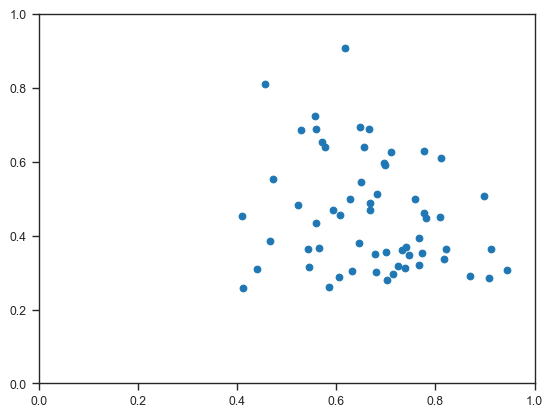

In [332]:
tmp_df = ddG_df.pivot_table(index=['mm'], columns=['dop'], values='ddG_37', aggfunc='std')
tmp_df['ratio'] = tmp_df.sl**2 / tmp_df.arr**2
plt.scatter(tmp_df.arr, tmp_df.sl)
plt.xlim([0,1])
plt.ylim([0,1])

Text(0.5, 1.0, 'variance ratio: SantaLucia / arr')

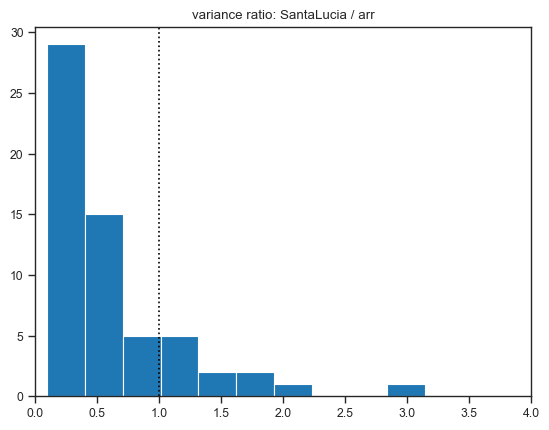

In [335]:
plt.hist(tmp_df.ratio)
plt.axvline(1, c='k', linestyle=':')
plt.xlim([0,4])
plt.title('variance ratio: SantaLucia / arr')

In [371]:
from scipy.stats import wasserstein_distance

In [485]:
tmp_df = ddG_df.reset_index().pivot_table(index=['mm','index'], columns=['dop'], values='ddG_37')

In [372]:
metric = {mm: wasserstein_distance(tmp_df.loc[mm].arr, tmp_df.loc[mm].sl) for mm in tmp_df.index.get_level_values(0)}

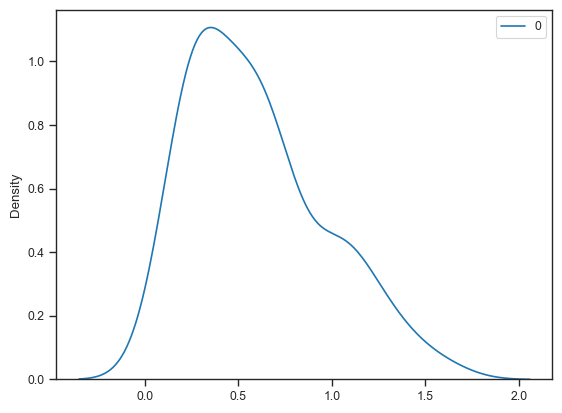

In [377]:
sns.kdeplot(metric.values())
plt.show()

In [385]:
mm = tmp_df.index.get_level_values(0)[0]

In [390]:
def ci_len(x):
    return np.percentile(x, 97.5) - np.percentile(x, 2.5)

In [393]:
ci_ratio = {mm: ci_len(tmp_df.loc[mm].sl) / ci_len(tmp_df.loc[mm].arr) for mm in tmp_df.index.get_level_values(0)}

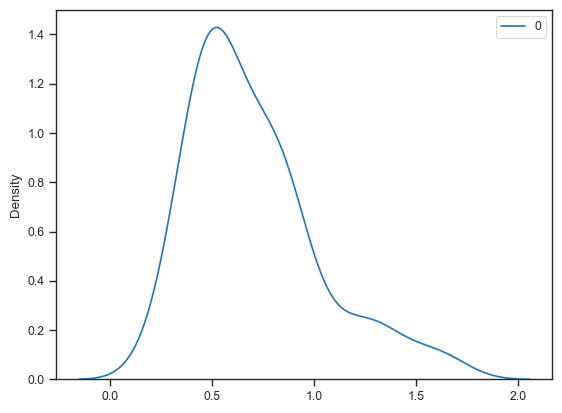

In [395]:
sns.kdeplot(ci_ratio.values())
plt.show()

In [2]:
from scipy.stats import kstest, ecdf

ImportError: cannot import name 'ecdf' from 'scipy.stats' (/Users/yuxi/opt/anaconda3/envs/nnn/lib/python3.8/site-packages/scipy/stats/__init__.py)

In [488]:
ks_pval = {mm: kstest(tmp_df.loc[mm].arr, tmp_df.loc[mm].sl).pvalue for mm in tmp_df.index.get_level_values(0)}

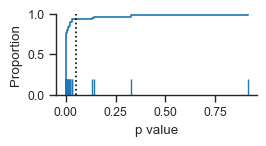

In [547]:
# fig, ax = plt.subplots(figsize=(5,3))
# ax.set_xscale('log')
sns.displot(list(ks_pval.values()),
             kind='ecdf', rug=True, rug_kws=dict(height=.2),
             log_scale=False,
             height=3.5*cm, aspect=2)#, bins=np.logspace(-6, 1, 10))
ax.yaxis.set_major_locator(MultipleLocator(.05))
plt.axvline(.05, c='k', linestyle=':')
plt.xlabel('p value')
util.save_fig('./fig/Fig3/mismatch/mm_spread_kstest_pval.pdf')

In [3]:
list(ks_pval.values())

NameError: name 'ks_pval' is not defined

In [419]:
tmp_df = pd.DataFrame(index=metric.keys(), data=metric.values(), columns=['distance']).join(pd.DataFrame(index=ci_ratio.keys(), data=ci_ratio.values(), columns=['ci_len_ratio']))

In [461]:
tmp_df['flank'] = [x.split(',')[0] for x in tmp_df.index]
tmp_df['flank_gc'] = [util.get_GC_content(x.replace('x','')) for x in tmp_df.flank]
tmp_df['mismatch'] = [x.split(', ')[1] for x in tmp_df.index]

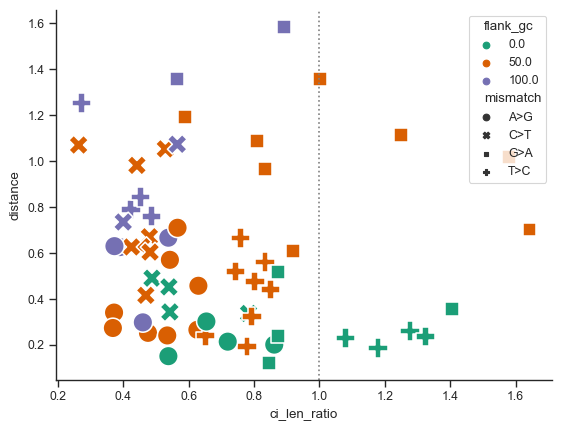

In [473]:
sns.scatterplot(y='distance', x='ci_len_ratio', data=tmp_df, style='mismatch', hue='flank_gc', s=200, palette='Dark2'
             )#kind='kde', fill=False)#, cmap='Reds')
plt.axvline(1, c='gray', linestyle=':')
sns.despine()

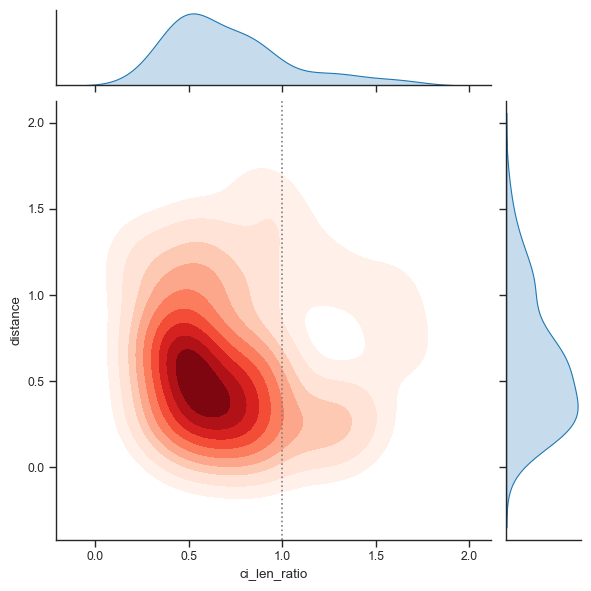

In [460]:
sns.jointplot(y='distance', x='ci_len_ratio', data=tmp_df, 
             kind='kde', fill=True, cmap='Reds', marginal_ticks=False)
plt.axvline(1, c='gray', linestyle=':')
sns.despine()

<Axes: xlabel='mismatch', ylabel='distance'>

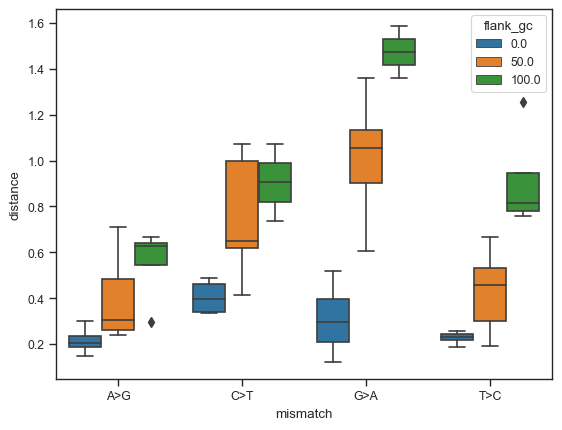

In [483]:
sns.boxplot(data=tmp_df, hue='flank_gc', x='mismatch', y='distance',)

# 08/08/2023

### Some palettes

In [ ]:
# the desaturated 6 color palette
palette = np.array([
    [252,84,84],
    [255,197,84],
    [96,186,100],
    [115,198,255],
    [148,94,234],
    [255,164,220]
]) / 256.


In [210]:
palette = np.array([
    [131,164,255],
    [249,126,43],
    [219,101,210],
    [148,94,234],
    [124,14,221],
    [0,148,68],
    [214,0,0],
    [25,137,30],
    [38,44,107],
    [142,4,150],  
]) / 256.

# 08/09/2023

In [ ]:
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
ax.tick_params(colors='k', width=.5)

# 08/12/2023

## Some intuitive plots of spread

In [5]:
df['pm2'] = [x[1] for x in df.RefSeq]
df['pm1'] = [x[2] for x in df.RefSeq]
df['pp1'] = [x[4] for x in df.RefSeq]
df['pp2'] = [x[5] for x in df.RefSeq]

<Axes: xlabel='dG_37', ylabel='Density'>

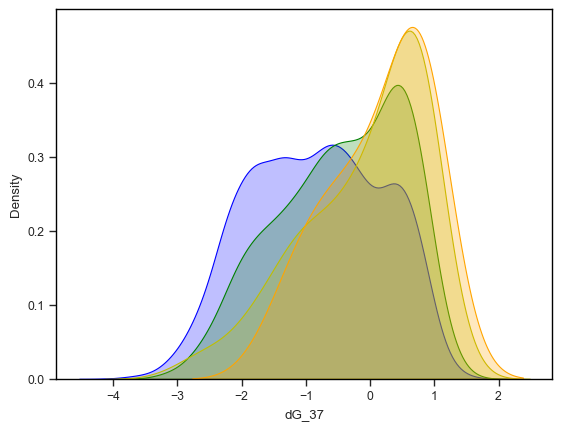

In [6]:
fig, ax = plt.subplots()
kwargs = dict(fill=True, ax=ax)
sns.kdeplot(df.dG_37, color='b', **kwargs)
sns.kdeplot(df.query('pm2 == "T"').dG_37, color='g', **kwargs)
sns.kdeplot(df.query('pm2 == "T" & pp2 == "T"').dG_37, color='y', **kwargs)
sns.kdeplot(df.query('pm2 == "T" & pp2 == "T" & pm1 == "C" & pp1 == "T"').dG_37, color='orange', **kwargs)

<Axes: xlabel='dH', ylabel='Tm'>

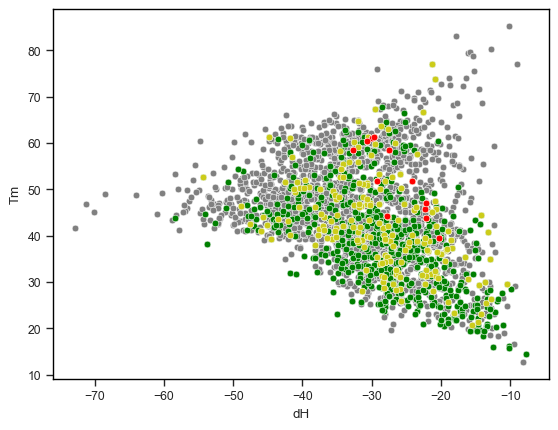

In [7]:
fig, ax = plt.subplots()
kwargs = dict(x='dH', y='Tm', ax=ax)
sns.scatterplot(data=df, color='gray', **kwargs)
sns.scatterplot(data=df.query('pm2 == "T"'), color='g', **kwargs)
sns.scatterplot(data=df.query('pm2 == "T" & pp2 == "C"'), color=[.8,.8,.1], **kwargs)
sns.scatterplot(data=df.query('pm2 == "T" & pp2 == "C" & pm1 == "C" & pp1 == "G"'), color='r', **kwargs)

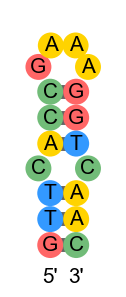

In [18]:
row = df.iloc[3,:]
draw_struct(row.RefSeq, row.TargetStruct)

## Variance per nt

In [35]:
import itertools

In [122]:
## Data organization ##
df = arr.query('ConstructType == "Centered"')
df = df[[x[0] == 'G' for x in df.RefSeq]]

for i in range(6):
    p = i + 1 if i < 5 else 14
    df['p%d'%i] = [x[p] for x in df.RefSeq]



pos_cols = ['p%d'%i for i in range(6)]
anova_df = pd.DataFrame(index=range(4**6), columns=pos_cols)
for i,seq in enumerate(itertools.product('ATCG', repeat=6)):
    anova_df.iloc[i,:] = seq

anova_df = anova_df.merge(df[pos_cols+['dG_37']], left_on=pos_cols, right_on=pos_cols, how='left')

In [69]:
## dumb filling, assume it's sorted for similarity (biased to 3')
ffill = anova_df['dG_37'].fillna(method='ffill')
bfill = anova_df['dG_37'].fillna(method='bfill')

imputed_df = anova_df.copy()
imputed_df['dG_37'] = np.nanmean(pd.concat([ffill, bfill], axis=1), axis=1)

In [70]:
from scipy.spatial import distance

In [82]:
from tqdm import tqdm

In [84]:
%%time
def hamming_distance(row1, row2):
    return distance.hamming(row1.values, row2.values)

def impute_with_hamming(ori_df, column_to_impute):
    # Find rows with missing values
    df = ori_df.copy()
    missing_rows = df[df[column_to_impute].isna()]
    print('#missing rows: ', len(missing_rows))
    complete_rows = df[~df[column_to_impute].isna()]
    complete_rows_feats = complete_rows.drop(column_to_impute, axis=1)
    
    for idx, missing_row in tqdm(missing_rows.iterrows()):

        # Compute distances to all other rows
        distances = complete_rows_feats.apply(lambda row: hamming_distance(missing_row.drop(column_to_impute), row), axis=1)
        
        # Find the index of the row with the smallest distance
        nearest_row_idx = distances.idxmin()

        # Impute the missing value
        df.at[idx, column_to_impute] = complete_rows.at[nearest_row_idx, column_to_impute]

    return df



imputed_df = impute_with_hamming(anova_df, 'dG_37')
print(imputed_df)



#missing rows:  1305


1305it [08:05,  2.69it/s]

     p0 p1 p2 p3 p4 p5     dG_37
0     A  A  A  A  A  A  0.845414
1     A  A  A  A  A  T  0.845414
2     A  A  A  A  A  C  0.845414
3     A  A  A  A  A  G  0.858242
4     A  A  A  A  T  A  0.674020
...  .. .. .. .. .. ..       ...
4091  G  G  G  G  C  G -2.546561
4092  G  G  G  G  G  A -2.074257
4093  G  G  G  G  G  T -1.946379
4094  G  G  G  G  G  C -0.938055
4095  G  G  G  G  G  G -1.578871

[4096 rows x 7 columns]
CPU times: user 8min, sys: 3.15 s, total: 8min 3s
Wall time: 8min 5s


In [85]:
imputed_df.to_csv('./data/models/processed/centered_mm_for_anova.csv')

In [120]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

total_variance = imputed_df['dG_37'].var()

contributions = []

for dimension in imputed_df.columns[:-1]:  # Assuming 'y' is the last column.
    formula = f'dG_37 ~ C({dimension})'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    between_group_variance = anova_table['sum_sq'][0]
    contribution = (between_group_variance / total_variance)# * 100
    contributions.append(contribution)


Interpreting color string as integer values


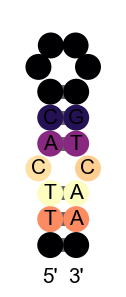

In [121]:
c = [0] + contributions[:5] + [0]*6 + contributions[3:5][::-1] + [contributions[5]] + contributions[:2][::-1] + [0]

draw_struct(row.RefSeq, '(((.(((....))).)))', c=c, cmap='magma')

In [123]:
anova_df.dropna(inplace=True)

total_variance = anova_df['dG_37'].var()

contributions = []

for dimension in anova_df.columns[:-1]:  # Assuming 'y' is the last column.
    formula = f'dG_37 ~ C({dimension})'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    between_group_variance = anova_table['sum_sq'][0]
    contribution = (between_group_variance / total_variance)# * 100
    contributions.append(contribution)


Interpreting color string as integer values


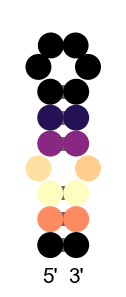

In [125]:
c = [0] + contributions[:5] + [0]*6 + contributions[3:5][::-1] + [contributions[5]] + contributions[:2][::-1] + [0]

draw_struct(' '*18, '(((.(((....))).)))', c=c, cmap='magma')

In [118]:
contributions

[426.4720521471442,
 562.9700340806369,
 527.7749799586755,
 221.16375964181506,
 83.76163930886455,
 504.21418504163904]

Tried to separate 5p and 3p but the results are similar. So I pooled them all.

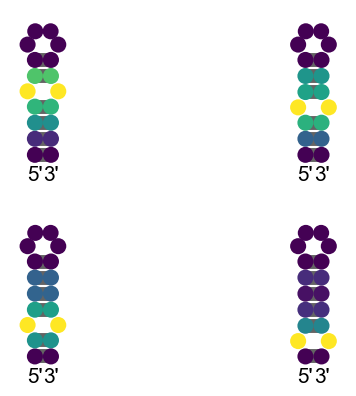

In [295]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df = arr.query("Series == 'MisMatches'")

## find parents ##
df['parent'] = df.apply(lambda row: find_mm_parent(row.RefSeq, row.TargetStruct, arr, which_side='3p'), axis=1)
df.dropna(subset=['parent'], inplace=True)

## clean output col ##
df['mismatch'] = df.parent.apply(lambda x: x[1][0])
df['context'] = df.parent.apply(lambda x: x[2])
df['parent'] = df.parent.apply(lambda x: x[0][0])

## get parent info ##
df = df.set_index('parent').join(arr[['dG_37', 'dG_37_se']], rsuffix='_parent').reset_index()

## add info ##
df['flank'] = df.context.apply(lambda x: x[0]+x[-1]+'x'+x[2:4])

df['ddG_37'] = (df.dG_37 - df.dG_37_parent).astype(float)
df['ddG_37_se'] = (df.dG_37_se + df.dG_37_se_parent).astype(float)

fig, ax = plt.subplots(2,2)
ax = ax.flatten()

for ind,target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    pos_cols = ['p%d'%i for i in range(len(target_struct))]

    for i in range(len(target_struct)):
        tmp_df['p%d'%i] = [x[i] for x in tmp_df.RefSeq]

    identical_pos_list = []
    for p in pos_cols:
        if len(np.unique(tmp_df[p])) < 4:
            identical_pos_list.append(p)
            tmp_df = tmp_df.drop(columns=p)

    pos_cols = [x for x in tmp_df.columns if x.startswith("p")]
    anova_df = tmp_df[pos_cols+['ddG_37']]

    total_variance = anova_df['ddG_37'].var()

    contributions = dict()

    for dimension in anova_df.columns[:-1]:  # Assuming 'y' is the last column.
        formula = f'ddG_37 ~ C({dimension})'
        model = ols(formula, data=anova_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        between_group_variance = anova_table['sum_sq'][0]
        contribution = (between_group_variance / total_variance)# * 100
        contributions[dimension] = contribution

    # print(contributions)
    n = len(target_struct)
    c = np.zeros(n)
    for key,value in contributions.items():
        p = int(key.replace('p',''))
        c[p] = np.log(value)

    draw_struct(' '*n, target_struct, c=c, cmap='viridis', ax=ax[ind])

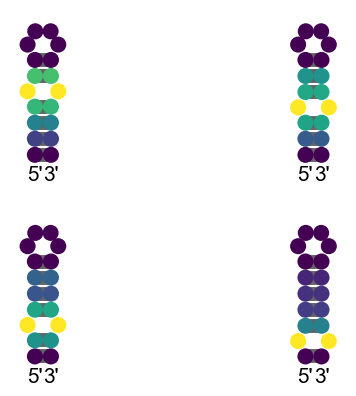

In [296]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df = arr.query("Series == 'MisMatches'")

## find parents ##
df['parent'] = df.apply(lambda row: find_mm_parent(row.RefSeq, row.TargetStruct, arr, which_side='5p'), axis=1)
df.dropna(subset=['parent'], inplace=True)

## clean output col ##
df['mismatch'] = df.parent.apply(lambda x: x[1][0])
df['context'] = df.parent.apply(lambda x: x[2])
df['parent'] = df.parent.apply(lambda x: x[0][0])

## get parent info ##
df = df.set_index('parent').join(arr[['dG_37', 'dG_37_se']], rsuffix='_parent').reset_index()

## add info ##
df['flank'] = df.context.apply(lambda x: x[0]+x[-1]+'x'+x[2:4])

df['ddG_37'] = (df.dG_37 - df.dG_37_parent).astype(float)
df['ddG_37_se'] = (df.dG_37_se + df.dG_37_se_parent).astype(float)

fig, ax = plt.subplots(2,2)
ax = ax.flatten()

for ind,target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    pos_cols = ['p%d'%i for i in range(len(target_struct))]

    for i in range(len(target_struct)):
        tmp_df['p%d'%i] = [x[i] for x in tmp_df.RefSeq]

    identical_pos_list = []
    for p in pos_cols:
        if len(np.unique(tmp_df[p])) < 4:
            identical_pos_list.append(p)
            tmp_df = tmp_df.drop(columns=p)

    pos_cols = [x for x in tmp_df.columns if x.startswith("p")]
    anova_df = tmp_df[pos_cols+['ddG_37']]

    total_variance = anova_df['ddG_37'].var()

    contributions = dict()

    for dimension in anova_df.columns[:-1]:  # Assuming 'y' is the last column.
        formula = f'ddG_37 ~ C({dimension})'
        model = ols(formula, data=anova_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        between_group_variance = anova_table['sum_sq'][0]
        contribution = (between_group_variance / total_variance)# * 100
        contributions[dimension] = contribution

    # print(contributions)
    n = len(target_struct)
    c = np.zeros(n)
    for key,value in contributions.items():
        p = int(key.replace('p',''))
        c[p] = np.log(value)

    draw_struct(' '*n, target_struct, c=c, cmap='viridis', ax=ax[ind])

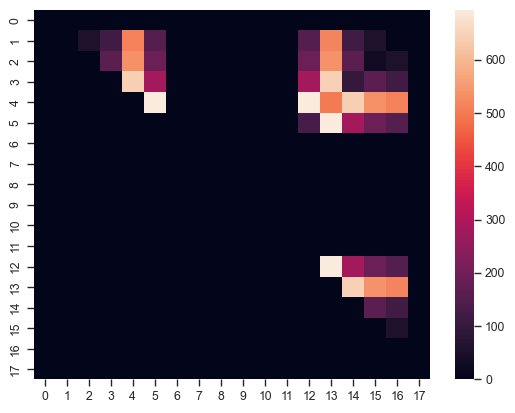

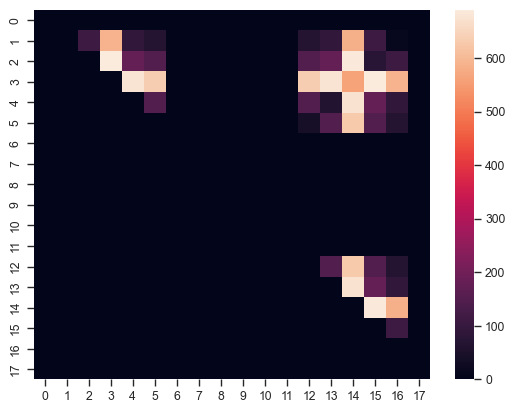

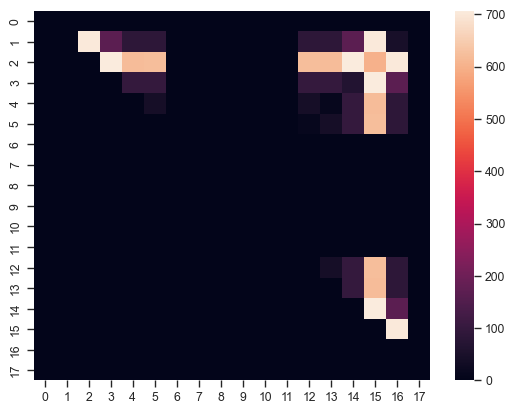

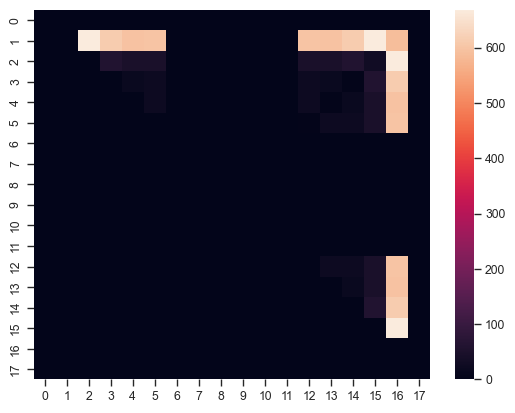

In [361]:
# fig, ax = plt.subplots(2,2)
# ax = ax.flatten()

df = df_with_parent.copy()
n = len(df['TargetStruct'].values[0])
# c_log = np.zeros((len(np.unique(df['TargetStruct'])), n))

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    pos_cols = ['p%d'%i for i in range(len(target_struct))]

    for i in range(len(target_struct)):
        tmp_df['p%d'%i] = [x[i] for x in tmp_df.RefSeq]

    identical_pos_list = []
    for p in pos_cols:
        if len(np.unique(tmp_df[p])) < 4:
            identical_pos_list.append(p)
            tmp_df = tmp_df.drop(columns=p)

    pos_cols = [x for x in tmp_df.columns if x.startswith("p")]

    pair_cols = ['_'.join(x) for x in itertools.combinations(pos_cols, 2)]
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        tmp_df[pair_cols[i]] = tmp_df.apply(lambda row: row[pair[0]] + row[pair[1]], axis=1)

    anova_df = tmp_df[pair_cols + ['ddG_37']]

    total_variance = anova_df['ddG_37'].var()

    contributions = dict()

    for dimension in anova_df.columns[:-1]:  # Assuming 'y' is the last column.
        formula = f'ddG_37 ~ C({dimension})'
        model = ols(formula, data=anova_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        between_group_variance = anova_table['sum_sq'][0]
        contribution = (between_group_variance / total_variance)# * 100
        contributions[dimension] = contribution

    # print(contributions)
    # n = len(target_struct)
    # c = np.zeros(n)
    # for key,value in contributions.items():
    #     p = int(key.replace('p',''))
    #     c[p] = np.log(value)
    # c_log[ind, :] = c

    # draw_struct(' '*n, target_struct, c=c, cmap='viridis', ax=ax[ind])

    # util.save_fig('./fig/Fig3/importance/single_mm_importance.pdf')

    thresh = np.mean(list(contributions.values()))

    contributions_has = {k:v for k,v in contributions.items() if v > thresh}

    c_mat = np.zeros((n,n))

    for k,v in contributions.items():
        pos1, pos2 = k.replace('p','').split('_')
        c_mat[int(pos1), int(pos2)] = v

    sns.heatmap(c_mat)
    plt.show()

# 08/13/2023

## Pairs of nt

In [372]:
import matplotlib.patches as patches
from matplotlib.path import Path

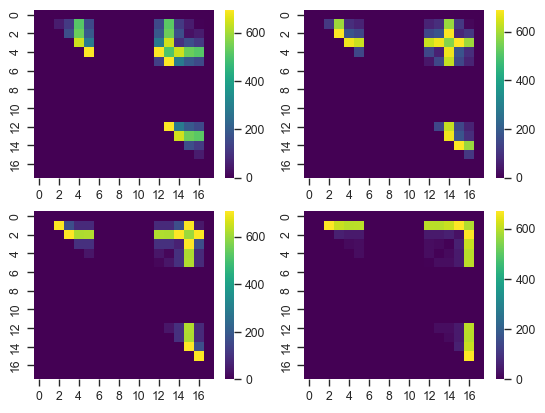

In [392]:
fig, ax = plt.subplots(2,2)
ax = ax.flatten()

df = df_with_parent.copy()
n = len(df['TargetStruct'].values[0])
# c_log = np.zeros((len(np.unique(df['TargetStruct'])), n))

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    pos_cols = ['p%d'%i for i in range(len(target_struct))]

    for i in range(len(target_struct)):
        tmp_df['p%d'%i] = [x[i] for x in tmp_df.RefSeq]

    identical_pos_list = []
    for p in pos_cols:
        if len(np.unique(tmp_df[p])) < 4:
            identical_pos_list.append(p)
            tmp_df = tmp_df.drop(columns=p)

    pos_cols = [x for x in tmp_df.columns if x.startswith("p")]

    pair_cols = ['_'.join(x) for x in itertools.combinations(pos_cols, 2)]
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        tmp_df[pair_cols[i]] = tmp_df.apply(lambda row: row[pair[0]] + row[pair[1]], axis=1)

    anova_df = tmp_df[pair_cols + ['ddG_37']]

    total_variance = anova_df['ddG_37'].var()

    contributions = dict()

    for dimension in anova_df.columns[:-1]:  # Assuming 'y' is the last column.
        formula = f'ddG_37 ~ C({dimension})'
        model = ols(formula, data=anova_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        between_group_variance = anova_table['sum_sq'][0]
        contribution = (between_group_variance / total_variance)# * 100
        contributions[dimension] = contribution

    thresh = np.mean(list(contributions.values()))
    contributions_has = {k:v for k,v in contributions.items() if v > thresh}

    c_mat = np.zeros((n,n))

    for k,v in contributions.items():
        pos1, pos2 = k.replace('p','').split('_')
        c_mat[int(pos1), int(pos2)] = v

    sns.heatmap(c_mat, cmap='viridis',ax=ax[ind])
    # plt.show()

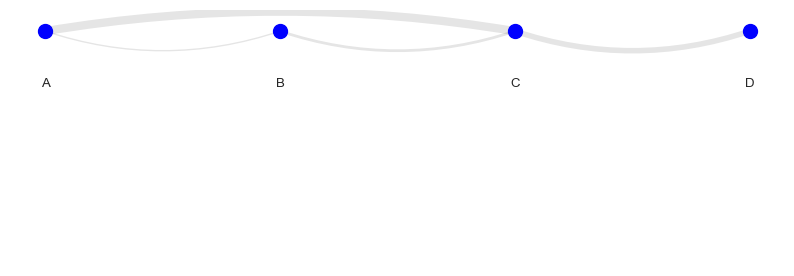

In [421]:
def plot_arc_diagram(nodes, edges, edge_weights=None, edge_width_factor=1, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    
    # Position the nodes along the x axis
    node_positions = {node: i for i, node in enumerate(nodes)}
    
    # Plot the nodes
    nodes_y = .5
    for node in nodes:
        ax.plot(node_positions[node], nodes_y, 'o', color='blue', markersize=10)
        ax.text(node_positions[node], nodes_y - 0.2, node, ha='center', va='top')
    
    if edge_weights is None:
        edge_weights = np.ones(len(edges))
    
    edge_weights = edge_width_factor * np.array(edge_weights)
    
    # Draw arcs for each edge
    for i,edge in enumerate(edges):
        start, end = edge
        start_pos, end_pos = node_positions[start], node_positions[end]
        
        # Use a Bezier curve for the arc for more control
        verts = [
            (start_pos, nodes_y),  # P0
            ((start_pos + end_pos) / 2, abs(start_pos - end_pos) / 3),  # P1
            (end_pos, nodes_y),  # P2
        ]

        codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
        
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', 
                                  lw=edge_weights[i], edgecolor='k', alpha=.1)
        ax.add_patch(patch)
    
    # Set axis properties
    ax.set_ylim(bottom=-.5) # avoid cropping out the node circles at the edge
    ax.set_aspect('equal')
    ax.axis('off')

# Test the function
nodes = list('ABCD')
edges = [('A', 'B'), ('B', 'C'), ('A', 'C'), ('C', 'D')]
edge_weights = np.array([1,2,6,4])
plot_arc_diagram(nodes, edges, edge_weights)

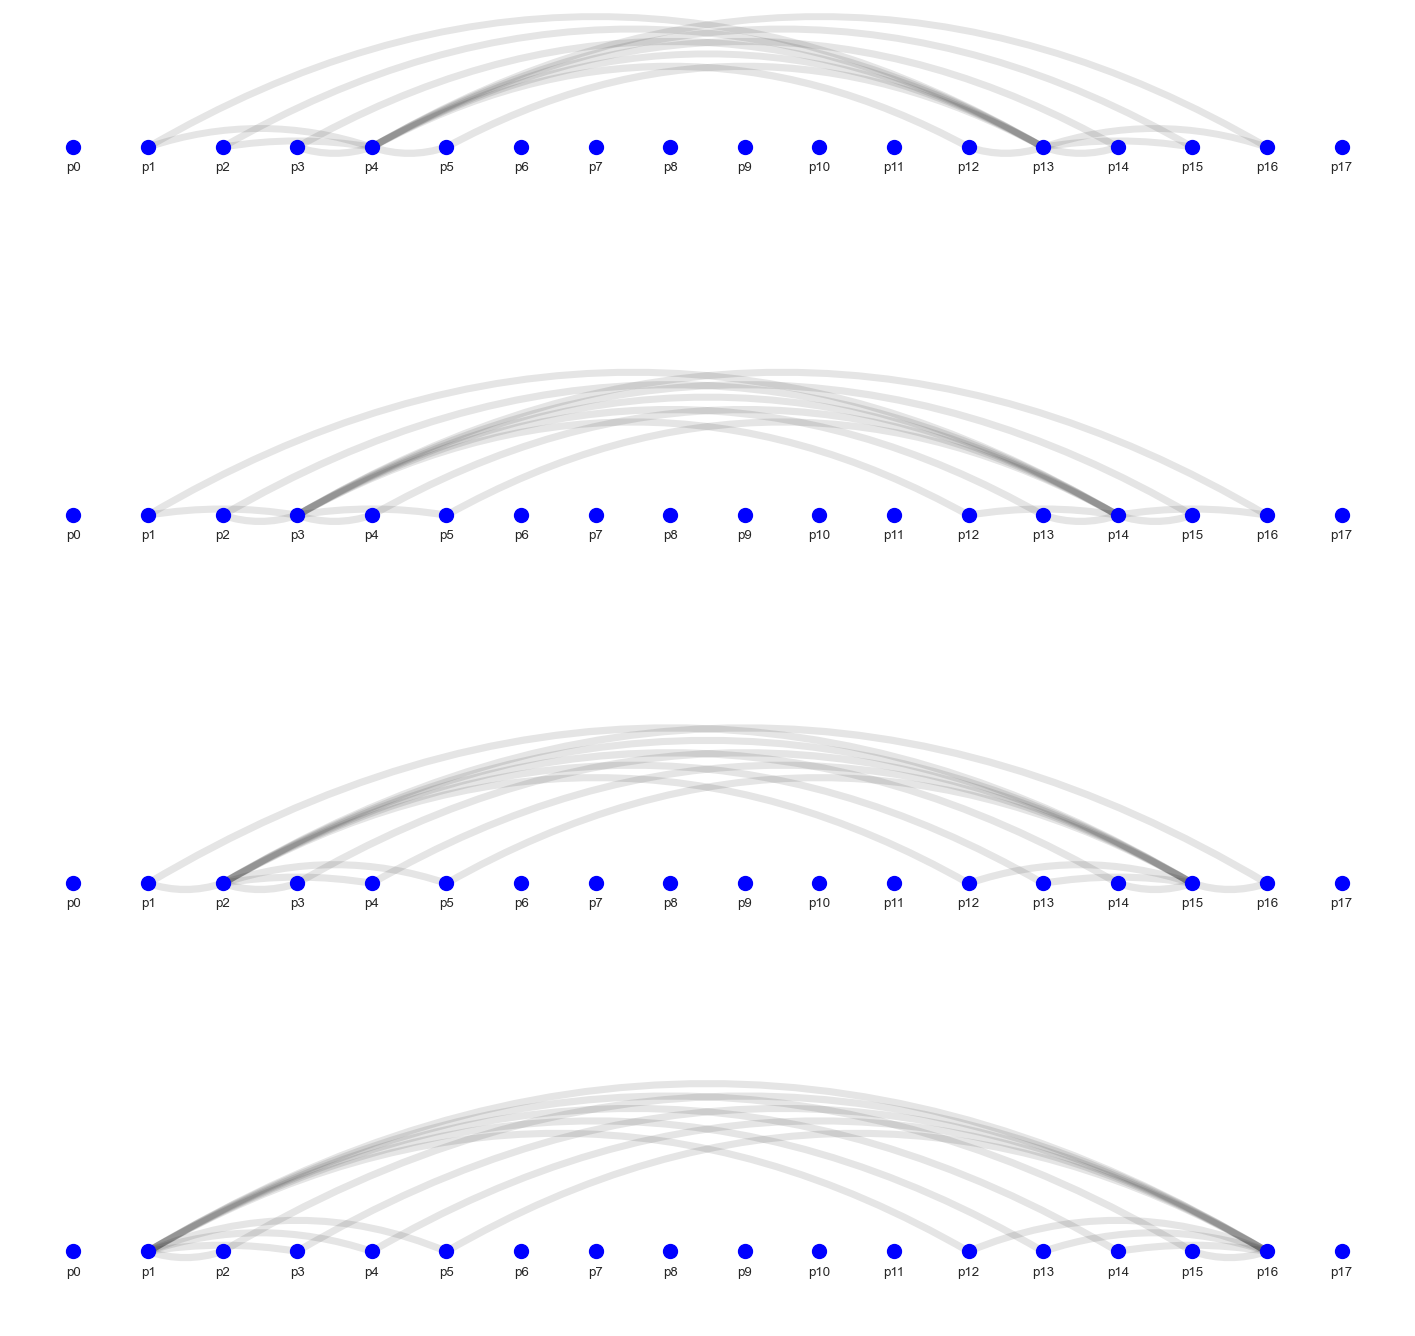

In [424]:
fig, ax = plt.subplots(4,1, figsize=(18,18))
ax = ax.flatten()

df = df_with_parent.copy()
n = len(df['TargetStruct'].values[0])

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    pos_cols = ['p%d'%i for i in range(len(target_struct))]

    for i in range(len(target_struct)):
        tmp_df['p%d'%i] = [x[i] for x in tmp_df.RefSeq]

    identical_pos_list = []
    for p in pos_cols:
        if len(np.unique(tmp_df[p])) < 4:
            identical_pos_list.append(p)
            tmp_df = tmp_df.drop(columns=p)

    pos_cols = [x for x in tmp_df.columns if x.startswith("p")]

    pair_cols = ['_'.join(x) for x in itertools.combinations(pos_cols, 2)]
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        tmp_df[pair_cols[i]] = tmp_df.apply(lambda row: row[pair[0]] + row[pair[1]], axis=1)

    anova_df = tmp_df[pair_cols + ['ddG_37']]

    total_variance = anova_df['ddG_37'].var()

    contributions = dict()

    for dimension in anova_df.columns[:-1]:  # Assuming 'y' is the last column.
        formula = f'ddG_37 ~ C({dimension})'
        model = ols(formula, data=anova_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        between_group_variance = anova_table['sum_sq'][0]
        contribution = (between_group_variance / total_variance)# * 100
        contributions[dimension] = contribution

    thresh = np.mean(list(contributions.values()))
    contributions_has = {k:v for k,v in contributions.items() if v > thresh}

    ## plotting
    nodes = ['p%d'%i for i in range(n)]
    edges = []
    edge_weights = []

    for edge_ind, (k,v) in enumerate(contributions_has.items()):
        pos1, pos2 = k.split('_')
        edges.append((pos1, pos2))
        edge_weights.append(np.log(v))
    
    plot_arc_diagram(nodes, edges, edge_weights, edge_width_factor=.8, ax=ax[ind])

This does not take individual nts into account... Need to regree them out.

# 08/14/2023

In [9]:
from nnn import variance
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [5]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df = arr.query("Series == 'MisMatches'")

## find parents ##
df_with_parent = pd.concat(
    [variance.find_mm_parent_df(df, arr, '5p'), variance.find_mm_parent_df(df, arr, '3p')],
    axis=0
)

df_with_parent.drop_duplicates(inplace=True)

In [6]:
df_with_parent

,index,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,...,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected,mismatch,context,dG_37_parent,dG_37_se_parent,flank,ddG_37,ddG_37_se
0,MMTM177,-33.451208,4.077735,-40.752007,-26.474865,42.670587,0.966379,41.554911,44.373866,-0.605813,...,-3.390976,-36.3,-0.102499,T>A,AAATAT,-2.577496,1.196206,ATxAT,1.971683,1.247747
1,MMTM177,-40.798769,4.025899,-48.484088,-33.673033,40.119544,0.544192,39.122872,40.957703,-0.401024,...,-3.150379,-33.4,-0.094406,T>C,ACATAT,-2.577496,1.196206,ATxAT,2.176473,1.256595
2,MMTM177,-44.789646,4.690609,-54.504775,-36.119239,50.372555,0.807522,49.244993,51.945722,-1.873369,...,-4.147813,-42.1,-0.118427,T>G,AGATAT,-2.577496,1.196206,ATxAT,0.704127,1.339891
3,MMTM177,-24.128296,2.696545,-31.658314,-18.130832,36.398939,1.324192,32.344753,39.706037,0.054451,...,-2.347491,-42.8,-0.126423,A>C,CCTATG,-2.577496,1.196206,CGxTA,2.631948,1.303936
4,MMTM177,-34.695808,3.971113,-44.576195,-26.682180,52.875645,1.217209,49.699371,56.053910,-1.655295,...,-3.422704,-46.3,-0.133645,A>T,TTGCTA,-2.577496,1.196206,TAxGC,0.922201,1.330213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3315,WC995,-16.018430,1.394011,-20.928685,-12.073064,39.989688,2.123510,34.000575,46.875291,-0.160344,...,-1.694262,-40.5,-0.121328,A>G,GTTAGC,-2.375539,0.186451,GCxTA,2.215195,0.280659
3316,WC995,-32.708039,2.669274,-43.204535,-25.503698,34.860733,0.383849,33.814358,36.154734,0.298589,...,-0.511152,-39.2,-0.120619,C>T,AGCGTT,-2.375539,0.186451,ATxCG,2.674129,0.246240
3317,WC998,-23.390930,3.233931,-34.439918,-13.979702,26.130639,1.173004,22.885268,30.371031,0.774780,...,-1.238172,-35.0,-0.105175,T>C,TACGCA,-1.223934,0.081470,TAxCG,1.998714,0.265886
3318,WC998,-32.856845,3.104622,-44.835963,-24.434982,35.199387,0.560858,33.761868,37.145904,0.224388,...,-0.963776,-38.2,-0.116041,A>G,TTATGA,-1.223934,0.081470,TAxAT,1.448322,0.161597


In [11]:
total_variance

0.7756082279435175

In [12]:
dimension

'p16'

In [26]:
p = model.params.values
p_a = p.copy()
p_a[0] = 0
group_pred = p_a + p[0]

In [28]:
np.var(group_pred) / total_variance

0.003084686466493301

In [29]:
model.rsquared

0.003006105703941553

In [21]:
model.predict(anova_df.iloc[:2,:])

4    2.135385
5    2.135385
dtype: float64

In [22]:
anova_df

,p1,p2,p3,p4,p5,p12,p13,p14,p15,p16,ddG_37
4,C,A,T,T,G,C,T,A,T,G,0.922201
5,C,A,T,C,G,C,T,A,T,G,1.665562
6,C,A,T,G,G,C,T,A,T,G,0.367852
11,T,T,A,T,T,A,G,T,A,A,2.834926
15,T,T,A,T,G,C,G,T,A,A,2.385253
...,...,...,...,...,...,...,...,...,...,...,...
3301,T,T,A,T,C,G,G,T,A,A,1.881645
3304,T,T,A,G,A,T,T,T,A,A,1.805262
3308,T,T,A,G,T,A,T,T,A,A,2.213175
3312,T,T,A,G,G,C,T,T,A,A,2.367070


In [30]:
dimension = 'p4'
formula = f'ddG_37 ~ C({dimension})'
model = ols(formula, data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
between_group_variance = anova_table['sum_sq'][0]

In [31]:
def get_group_pred(model):
    p = model.params.values
    p_a = p.copy()
    p_a[0] = 0
    group_pred = p_a + p[0]
    return group_pred

In [38]:
grand_mean = np.mean(anova_df.ddG_37)

In [45]:
np.sum((get_group_pred(model) - grand_mean)**2)# / np.sum((anova_df.ddG_37 - grand_mean)**2)

0.9298969790879555

In [41]:
np.mean(get_group_pred(model))# / total_variance

2.111470201698679

In [77]:
y = anova_df.ddG_37.values
np.sum((y - np.mean(y))**2)

781.9156419070774

In [33]:
anova_table

,sum_sq,df,F,PR(>F)
C(p4),382.890434,3.0,233.722098,1.852710e-126
Residual,905.394832,1658.0,NaN,NaN


In [47]:
anova_df.groupby('p4').apply(np.mean)

,ddG_37
p4,
A,2.472617
C,2.699663
G,1.632212
T,1.641389


In [69]:
def get_group_pred(model):
    p = model.params.values
    p_a = p.copy()
    p_a[0] = 0
    group_pred = p_a + p[0]
    return group_pred

def get_ssb(df, group_col, fit_model=False):
    y = df.iloc[:,-1]
    tot_mean = np.mean(y)
    # sst = np.sum((y - tot_mean)**2)
    
    if not fit_model:
        group_means = df.groupby(group_col).apply(np.mean).values
        ssb = np.sum((group_means - tot_mean)**2)
    else:
        formula = f'ddG_37 ~ C({dimension})'
        model = ols(formula, data=anova_df).fit()
        group_pred = get_group_pred(model)
        ssb = np.sum((group_pred - tot_mean)**2)
    # ssw = sst - ssb
    
    return ssb

In [70]:
get_ssb(anova_df, 'p5', fit_model=True)

0.6349040189263508

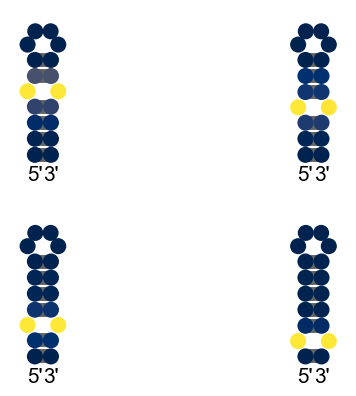

In [74]:
fig, ax = plt.subplots(2,2)
ax = ax.flatten()

df = df_with_parent.copy()
n = len(df['TargetStruct'].values[0])
c_log = np.zeros((len(np.unique(df['TargetStruct'])), n))

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    pos_cols = ['p%d'%i for i in range(len(target_struct))]

    for i in range(len(target_struct)):
        tmp_df['p%d'%i] = [x[i] for x in tmp_df.RefSeq]

    identical_pos_list = []
    for p in pos_cols:
        if len(np.unique(tmp_df[p])) < 4:
            identical_pos_list.append(p)
            tmp_df = tmp_df.drop(columns=p)

    pos_cols = [x for x in tmp_df.columns if x.startswith("p")]
    anova_df = tmp_df[pos_cols+['ddG_37']]

    total_variance = anova_df['ddG_37'].var()

    contributions = dict()

    for dimension in anova_df.columns[:-1]:  # Assuming 'y' is the last column.
        ssb = get_ssb(anova_df, dimension, fit_model=True)
        contribution = ssb#(between_group_variance / total_variance)# * 100
        contributions[dimension] = contribution

    # print(contributions)
    n = len(target_struct)
    c = np.zeros(n)
    for key,value in contributions.items():
        p = int(key.replace('p',''))
        c[p] = value#np.log(value + 1)
    c_log[ind, :] = c
    
    draw_struct(' '*n, target_struct, c=c, cmap='cividis', ax=ax[ind])
    
# util.save_fig('./fig/Fig3/importance/single_mm_importance.pdf')

<Axes: >

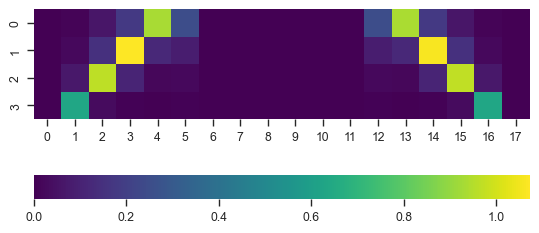

In [75]:
sns.heatmap(c_log, cmap='viridis', square=True,
            cbar_kws=dict(orientation='horizontal'))

# util.save_fig('./fig/Fig3/importance/single_mm_importance_heatmap.pdf')

In [67]:
c_log

array([[0.        , 0.00952682, 0.05718564, 0.16437529, 0.65746662,
        0.22246895, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.22246895, 0.66083453, 0.16437529,
        0.05718564, 0.00952682, 0.        ],
       [0.        , 0.02276755, 0.13760103, 0.72821706, 0.11387701,
        0.0815815 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.0815815 , 0.11387701, 0.72371574,
        0.13760103, 0.02276755, 0.        ],
       [0.        , 0.0676188 , 0.67515681, 0.09983031, 0.01882482,
        0.02151777, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.02151777, 0.01882482, 0.09983031,
        0.67641448, 0.0676188 , 0.        ],
       [0.        , 0.4915841 , 0.03216367, 0.00547727, 0.00368476,
        0.00431594, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00431594, 0.00368476, 0.00547727,
        0.03216367, 0.4915841 , 0.        ]])

In [294]:
def find_mm_parent(seq, struct, arr, which_side='both'):
    def get_parent_candidates(seq, struct):
        """
        parent1 is mutated at the 3' side, parent2 at the 5' side
        """
        assert which_side in {'both', '5p', '3p'}
        
        if '.(.' in struct:
            return None, None
        
        
        idxmm = (('('+struct).find('((.(') + 1, (struct+')').find(').))') + 1)
        if idxmm[0] == 0 or idxmm[1] == 1:
            return None, None
        else:
            parent1 = replace_at_index(seq, bp_dict[seq[idxmm[0]]], idxmm[1])
            mm1 = bp_dict[seq[idxmm[0]]] + '>' + seq[idxmm[1]]
            parent2 = replace_at_index(seq, bp_dict[seq[idxmm[1]]], idxmm[0])
            mm2 = bp_dict[seq[idxmm[1]]] + '>' + seq[idxmm[0]]
            context = seq[idxmm[0]-1:idxmm[0]+2] + seq[idxmm[1]-1:idxmm[1]+2]
            
            if which_side == 'both':
                return {parent1: mm1, parent2: mm2}, context
            elif which_side == '5p':
                return {parent2: mm2}, context
            elif which_side == '3p':
                return {parent1: mm1}, context
        
    bp_dict = dict(A='T', C='G', T='A', G='C')
    parent_candidates, context = get_parent_candidates(seq, struct)
    
    if parent_candidates is None:
        return np.nan
    
    idx_parent = []
    mm = []
    for candidate in parent_candidates:
        try:
            idx_parent.append(arr.RefSeq.tolist().index(candidate))
            mm.append(parent_candidates[candidate])
        except:
            continue
            
    if len(idx_parent) == 0:
        return np.nan
    else:
        return (arr.iloc[idx_parent].index.tolist(), mm, context)

def find_mm_parent_df(mm_df, arr, which_side):
    df = mm_df.copy()
    df['parent'] = df.apply(lambda row: find_mm_parent(row.RefSeq, row.TargetStruct, arr, which_side=which_side), axis=1)
    df.dropna(subset=['parent'], inplace=True)
    
    ## clean output col ##
    df['mismatch'] = df.parent.apply(lambda x: x[1][0])
    df['context'] = df.parent.apply(lambda x: x[2])
    df['parent'] = df.parent.apply(lambda x: x[0][0])

    ## get parent info ##
    df = df.set_index('parent').join(arr[['dG_37', 'dG_37_se']], rsuffix='_parent').reset_index()

    ## add info ##
    df['flank'] = df.context.apply(lambda x: x[0]+x[-1]+'x'+x[2:4])

    df['ddG_37'] = (df.dG_37 - df.dG_37_parent).astype(float)
    df['ddG_37_se'] = (df.dG_37_se + df.dG_37_se_parent).astype(float)
    
    return df

In [115]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df = arr.query("Series == 'MisMatches'")

## find parents ##
df_with_parent = pd.concat(
    [variance.find_mm_parent_df(df, arr, '5p'), variance.find_mm_parent_df(df, arr, '3p')],
    axis=0
)

df_with_parent.drop_duplicates(inplace=True)

In [116]:
df = df_with_parent.copy()
target_struct = df.TargetStruct.values[0]
n = len(target_struct)
tmp_df = df[df.TargetStruct == target_struct]
anova_df = variance.get_pos_df(tmp_df, n=n)

In [106]:
c1, c2 = 'p3', 'p4'
cp = f'{c1}_{c2}'
y_col = 'ddG_37'

y = anova_df[y_col]

anova_df[cp] = anova_df.apply(lambda row: row[c1] + row[c2], axis=1)

formula = f'{y_col} ~ C({c1}) + C({c2})'
model_sep = ols(formula, data=anova_df).fit()

formula = f'{y_col} ~ C({cp})'
model_joint = ols(formula, data=anova_df).fit()

model_joint.rsquared - model_sep.rsquared

0.016547204824649997

In [104]:
formula = f'{y_col} ~ C({c1}) + C({c2})'
model = ols(formula, data=anova_df).fit()
model.rsquared

0.3983439268057569

In [103]:
formula = f'{y_col} ~ C({cp})'
model = ols(formula, data=anova_df).fit()
model.rsquared

0.4148911316304069

In [118]:
variance.get_sum_sq_explained_cp(anova_df, c1, c2)

0.016547204824649997

In [129]:
def replace_at_index(s:str, newstring:str, idx:int):
    return s[:idx] + newstring + s[idx + 1:]
  
def find_mm_parent(seq, struct, arr):
    def get_parent_candidates(seq, struct):
        if '.(.' in struct:
            return None, None
        
        bp_dict = dict(A='T', C='G', T='A', G='C')
        idxmm = (('('+struct).find('((.(') + 1, (struct+')').find(').))') + 1)
        if idxmm[0] == 0 or idxmm[1] == 1:
            return None, None
        else:
            parent1 = replace_at_index(seq, bp_dict[seq[idxmm[0]]], idxmm[1])
            mm1 = bp_dict[seq[idxmm[0]]] + '>' + seq[idxmm[1]]
            parent2 = replace_at_index(seq, bp_dict[seq[idxmm[1]]], idxmm[0])
            mm2 = bp_dict[seq[idxmm[1]]] + '>' + seq[idxmm[0]]
            # context = seq[idxmm[0]-1:idxmm[0]] + '.' + seq[idxmm[0]+1: idxmm[0]+2]
            context = seq[idxmm[0]-1:idxmm[0]+2] + seq[idxmm[1]-1:idxmm[1]+2]
            return {parent1: mm1, parent2: mm2}, context
        
    parent_candidates, context = get_parent_candidates(seq, struct)
    
    if parent_candidates is None:
        return np.nan
    
    idx_parent = []
    mm = []
    for candidate in parent_candidates:
        try:
            idx_parent.append(arr.RefSeq.tolist().index(candidate))
            mm.append(parent_candidates[candidate])
        except:
            continue
            
    if len(idx_parent) == 0:
        return np.nan
    else:
        return (arr.iloc[idx_parent].index.tolist(), mm, context)
    
def get_santalucia_mm_ddG(row):
    def unmutate(nt):
        return nt.replace(mismatch[2], mismatch[0])
        
    context = row['context']
    mismatch = row['mismatch']
    
    nn1 = context[0] + context[1] + '_' + context[4] + context[5]
    nn2 = context[3] + context[4] + '_' + context[1] + context[2]
    dG_mm = sl_mm.loc[nn1, 'dG_37'] + sl_mm.loc[nn2, 'dG_37']
    
    wc_nn1 = nn1[0] + unmutate(nn1[1]) + '_' + unmutate(nn1[3]) + nn1[4]
    wc_nn2 = nn2[0] + unmutate(nn2[1]) + '_' + unmutate(nn2[3]) + nn2[4]
    dG_wc = sl_mm.loc[wc_nn1, 'dG_37'] + sl_mm.loc[wc_nn2, 'dG_37']
    
    return dG_mm - dG_wc


def get_explained_var(y, pred):
    var_dict = defaultdict()

    var_dict['total'] = np.var(y)
    var_dict['unexplained'] = np.var((y - pred))
    var_dict['explained'] =  var_dict['total'] - var_dict['unexplained']
    var_dict['explained_ratio'] = var_dict['explained'] / var_dict['total']
    var_dict['unexplained_ratio'] = var_dict['unexplained'] / var_dict['total']
    return var_dict

def bootstrap_ddG_37_sl(tmp_df):
    n = 1 # num sample per datapoint
    bootstrap = np.zeros((len(tmp_df), n))

    for i,row in tmp_df.iterrows():
        mu = row.ddG_37_sl
        sigma = row.ddG_37_se
        bootstrap[i,:] = np.random.normal(mu, sigma, size=n)
        
    return bootstrap.flatten()


def ci_len(x):
    return np.percentile(x, 97.5) - np.percentile(x, 2.5)

# 08/15/2023

Moved some of the early explorations for `get_variance()` from the figure 3 notebook to here.

### Assess multiple versions of variance

#### Assume sigma independent of y

In [34]:
y = df.ddG_37.values
y_hat = df.ddG_37_sl.values
sigma = df.ddG_37_se.values
n = df.shape[0]

var_tot = np.sum((y - np.mean(y))**2)/ n
var_tech = np.sum(sigma**2) / n
var_bio = var_tot - var_tech
var_res = np.sum((y - y_hat)**2) / n
var_unexplained = var_res - var_tech

print('total\ttech\tbio\tres\t?')
print('%.2f\t%.2f\t%.2f\t%.2f\t%.2f' % (var_tot, var_tech, var_bio, var_res, var_unexplained))

total	tech	bio	res	?
1.07	0.15	0.93	0.77	0.62


#### Is sigma really independent of y?

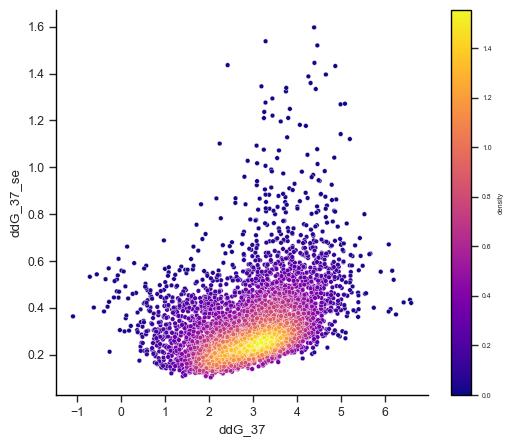

In [23]:
plotting.plot_colored_scatter_comparison(df, 'ddG_37', 'ddG_37_se')

<Axes: xlabel='ddG_37', ylabel='ddG_37_se'>

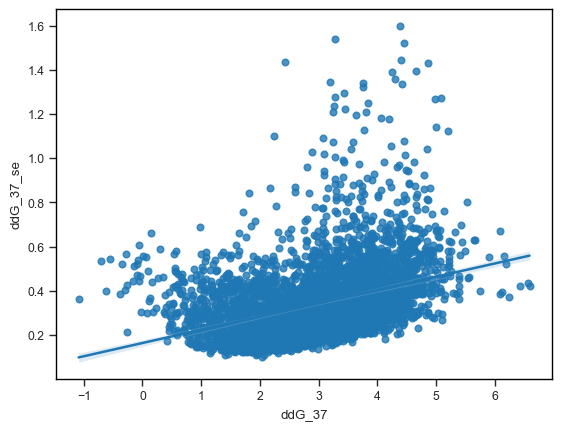

In [31]:
sns.regplot(data=df, x='ddG_37', y='ddG_37_se')

The answer is clearly NO.
The dependency is not too huge tho.

#### Regress the dependency

In [46]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(y.reshape(-1,1), sigma)
a = model.coef_[0]
b = model.intercept_
print('sigma = %.2fy + %.2f' % (a,b))

var_tech_adj = np.sum((model.predict(y.reshape(-1,1)))**2) / n
print('\nmeasurement variance before and after adjustment:\n %.2f, %.2f\n' % (var_tech, var_tech_adj))

print('total\ttech\tbio\tres\t?')
print('%.2f\t%.2f\t%.2f\t%.2f\t%.2f' % (var_tot, var_tech_adj, var_bio, var_res, var_res - var_tech_adj))

sigma = 0.06y + 0.16

measurement variance before and after adjustment:
 0.15, 0.12

total	tech	bio	res	?
1.07	0.12	0.93	0.77	0.65


In [239]:
def get_variances(y, sigma, y_hat, 
                  regress_sigma=False, sigma_model=None, return_model=False,
                  verbose=True):
    """
    Args:
        sigma_model - LinearRegression, if None fit afresh
    """
    n = len(y)

    var = defaultdict()
    var['tot'] = np.sum((y - np.mean(y))**2)/ n
    var['model'] = np.sum((y_hat - np.mean(y_hat))**2) / n
    
    if regress_sigma:
        if sigma_model is None:
            model = LinearRegression()
            model.fit(y.reshape(-1,1), sigma)
        else:
            model = sigma_model
        
        var['tech'] = np.sum((model.predict(y.reshape(-1,1)))**2) / n
        
        if verbose:
            a = model.coef_[0]
            b = model.intercept_
            print('sigma = %.2fy + %.2f\n' % (a,b))
            
    else:
        var['tech'] = np.sum(sigma**2) / n
        
    var['bio'] = var['tot'] - var['tech']
    var['res'] = np.sum((y - y_hat)**2) / n
    var['?'] = var['res'] - var['tech']
    
    if verbose:
        print('\t'.join(var.keys()))
        print('%.2f\t'*len(var) % tuple(var.values()))
    
    if return_model:
        return var, model
    else:
        return var

## ddG scatterplots

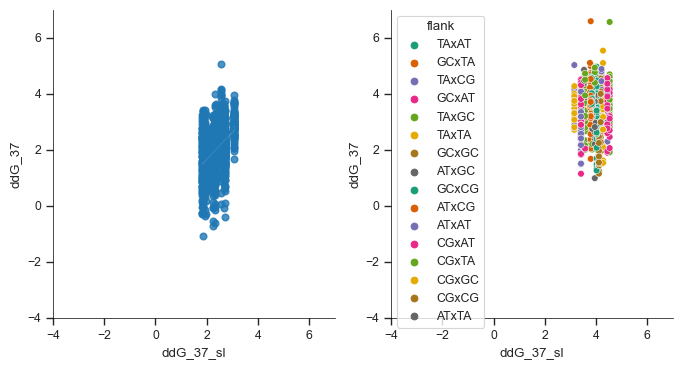

In [397]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
sns.regplot(data=df.query('mismatch == "A>G"'), y='ddG_37', x='ddG_37_sl', #hue='flank', palette='Dark2',
                ax=ax[0])
sns.scatterplot(data=df.query('mismatch == "T>C"'), y='ddG_37', x='ddG_37_sl', hue='flank', palette='Dark2',
                ax=ax[1])
for a in ax:
    a.set_xlim((-4,7))
    a.set_ylim((-4,7))
sns.despine()

## First version of variance bar plot

sigma = 0.06y + 0.16

tot	model	tech	bio	res	?
1.07	0.98	0.12	0.95	0.77	0.65	


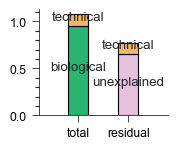

In [500]:
def plot_variances(var, ax, label_text=True, legend=False):
    palette = np.array([
        [42,182,115],
        [246,182,102],
        [230,194,220],
        [219,101,210], 
        [148,94,234],
    ]) / 256.
    kwargs = dict(width=.4, edgecolor='k')
    ax.bar(x=['total'], height=var['bio'], label='biological', color=palette[0], **kwargs)
    ax.bar(x=['total'], height=var['tech'], bottom=var['bio'], label='technical', color=palette[1], **kwargs)

    # ax.bar('model', var['model'], label='model', color=palette[3],**kwargs)
    ax.bar('residual', var['?'], label='unexplained', color=palette[2], **kwargs)
    ax.bar('residual', var['tech'], bottom=var['?'], color=palette[1], **kwargs)
    
    if label_text:
        ax.text(0, var['bio']/2, 'biological', ha='center')
        ax.text(0, var['bio']+var['tech']/2, 'technical', ha='center')
        ax.text(1, var['?']+var['tech']/2, 'technical', ha='center')
        ax.text(1, var['?']/2, 'unexplained', ha='center')

    if legend:
        plt.legend()
        
    sns.despine()
    ax.set_xlim([-.8,1.8])
    ax.set_ylim(bottom=0)

    
y = df.ddG_37.values
y_hat = df.ddG_37_sl.values
sigma = df.ddG_37_se.values
var, sigma_model = get_variances(y, sigma, y_hat, return_model=True, verbose=True)

matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
ax.tick_params(colors='k', width=.5)

plot_variances(var, ax)
ax.yaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.1))

util.save_fig('./fig/Fig3/mismatch/mm_variance_bar_all.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


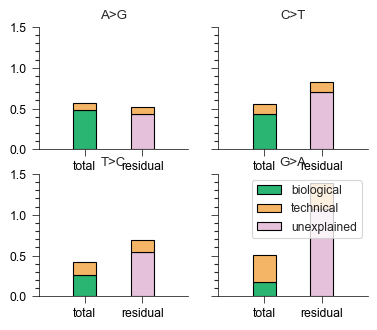

In [539]:
fig, ax = plt.subplots(2,2,sharey=True, figsize=(4.25*cm,3.5*cm))
ax = ax.flatten()

matplotlib.rc('axes',edgecolor='k', linewidth=.5)

metric_dict = dict()
for i,mm in enumerate(['A>G', 'C>T', 'T>C', 'G>A']):
    tmp_df = df.query('mismatch == "%s"' % mm)
    y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
    var = get_variances(y, sigma, y_hat, regress_sigma=False, verbose=False)
    plot_variances(var, ax=ax[i], label_text=False, legend=True)
    metric_dict[mm] = (var['bio'] - var['?']) / var['bio']
    ax[i].set_title(mm)
    ax[i].yaxis.set_major_locator(MultipleLocator(.5))
    ax[i].yaxis.set_minor_locator(MultipleLocator(.1))
    ax[i].tick_params(colors='k', width=.5)
    ax[i].set_ylim([0,1.5])

util.save_fig('./fig/Fig3/mismatch/mm_variance_bar_by_mismatch.pdf')

In [ ]:
def plot_variances(var, xticklabel, ax, label_text=False, legend=False):
    palette = np.array([
        [42,182,115],
        [246,182,102],
        [230,194,220],
        [219,101,210], 
        [148,94,234],
    ]) / 256.
    kwargs = dict(width=.4, edgecolor='k')
    ax.bar(xticklabel, height=var['tech'], bottom=var['bio'], label='technical', color=palette[1], **kwargs)
    ax.bar(xticklabel, var['?'], bottom=var['bio'] - var['?'], label='unexplained', color=palette[2], **kwargs)
    ax.bar(xticklabel, var['bio'] - var['?'], label='explained', color=palette[0], **kwargs)
    
    if label_text:
        ax.text(0, var['bio']/2, 'biological', ha='center')
        ax.text(0, var['bio']+var['tech']/2, 'technical', ha='center')
        ax.text(1, var['?']+var['tech']/2, 'technical', ha='center')
        ax.text(1, var['?']/2, 'unexplained', ha='center')

    if legend:
        plt.legend()
        
    sns.despine()
    # ax.set_xlim([-.8,.8])
    # ax.set_ylim(bottom=0)

y = df.ddG_37.values
y_hat = df.ddG_37_sl.values
sigma = df.ddG_37_se.values
var= variance.get_variances(y, sigma, y_hat, verbose=True)

matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
ax.tick_params(colors='k', width=.5)

plot_variances(var, 'total', ax, label_text=False)
ax.yaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.1))

# plt.legend()

util.save_fig('./fig/Fig3/mismatch/mm_variance_bar_all.pdf')

# 08/16/2023

### ci ratio

`ddG_df -> tmp_df -> ci_ratio`

In [20]:
tmp_df = ddG_df.reset_index().pivot_table(index=['mm','index'], columns=['dop'], values='ddG_37')

ci_ratio = [variance.ci_len(tmp_df.loc[mm].sl) / variance.ci_len(tmp_df.loc[mm].arr) for mm in tmp_df.index.get_level_values(0)]
# ci_diff = [ci_len(tmp_df.loc[mm].arr) - ci_len(tmp_df.loc[mm].sl) for mm in tmp_df.index.get_level_values(0)]

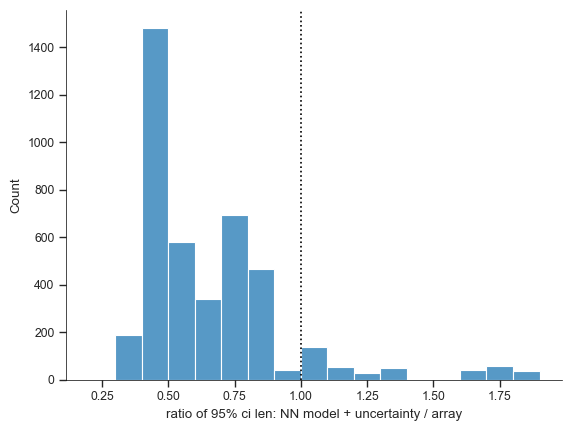

In [21]:
sns.histplot(ci_ratio, bins=np.arange(0.2,2,.1))
plt.axvline(1, c='k', linestyle=':')
plt.xlabel('ratio of 95% ci len: NN model + uncertainty / array')
sns.despine()
util.save_fig('./fig/Fig3/mismatch/mm_spread_ci_len_ratio.pdf')

In [22]:
## get the numbers in the plot ##
np.sum(np.array(ci_ratio) < 1), len(ci_ratio), np.sum(np.array(ci_ratio) > 1)

(3791, 4189, 398)

### k-s test

In [23]:
ks_pval = [stats.kstest(tmp_df.loc[mm].arr, tmp_df.loc[mm].sl).pvalue for mm in tmp_df.index.get_level_values(0)]

fig, ax = plt.subplots()
sns.displot(list(ks_pval),
             kind='ecdf', rug=True, rug_kws=dict(height=.2),
             log_scale=False,
             height=3.5*cm, aspect=2)#, bins=np.logspace(-6, 1, 10))
ax.yaxis.set_major_locator(MultipleLocator(.05))
plt.axvline(.05, c='k', linestyle=':')
plt.xlabel('p value')
util.save_fig('./fig/Fig3/mismatch/mm_spread_kstest_pval.pdf')

#### sigma adjusted

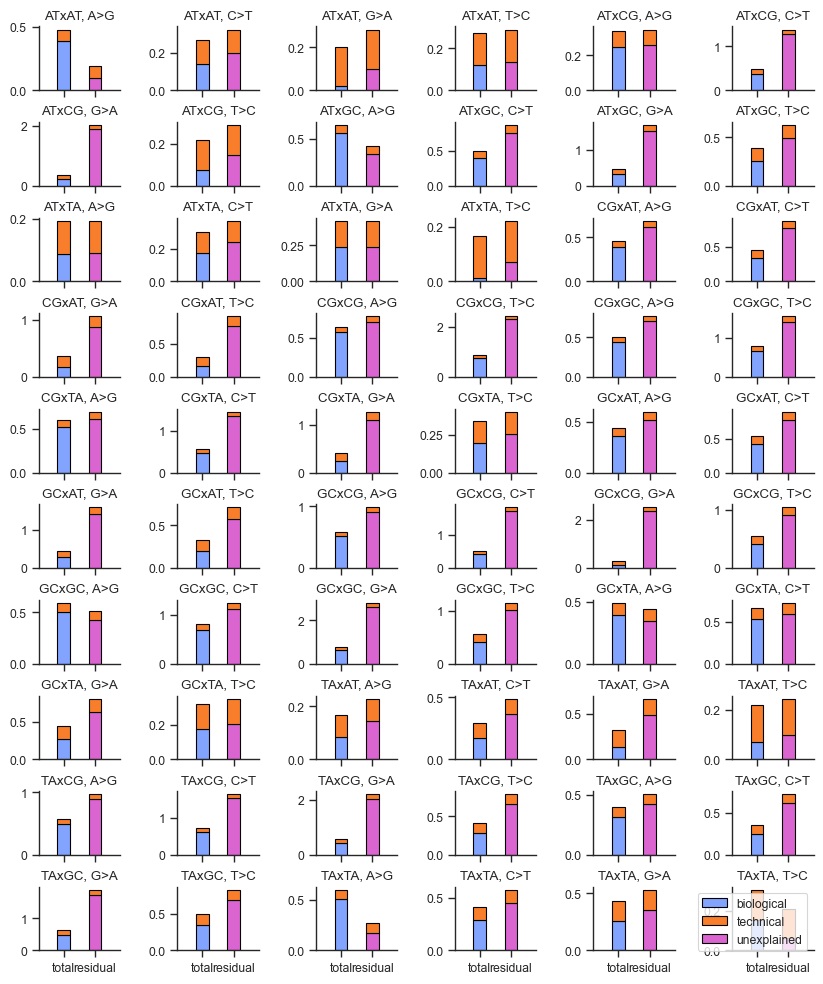

In [275]:
kwargs = dict(fill=True)
flanks, mismatches = np.unique(df.flank), np.unique(df.mismatch)

fig, ax = plt.subplots(10,6,figsize=(10,12), sharey=False, sharex=True)
ax = ax.flatten()

i = 0
var_df = pd.DataFrame(columns=var.keys())

for f in flanks:
    for m in mismatches:
        query = f'flank == "{f}" & mismatch == "{m}"'
        mm = f'{f}, {m}'
        tmp_df = df.query(query).reset_index()
        
        if len(tmp_df) > 10:           
            y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
            var = get_variances(y, sigma, y_hat, regress_sigma=True, sigma_model=sigma_model, verbose=False)
            tmp_df = pd.DataFrame(data=var, index=[mm])
            var_df = pd.concat([var_df, tmp_df])
            
            kwargs['ax'] = ax[i]
            ax[i].set_title(mm)
            plot_variances(var, ax[i], label_text=False)
            i += 1
        
var_df['res_lt_tot'] = var_df.eval('res < tot')
plt.legend()
plt.subplots_adjust(hspace=.5, wspace=.7)

util.save_fig('./fig/Fig3/mismatch/mm_variance_bar_grid.pdf')

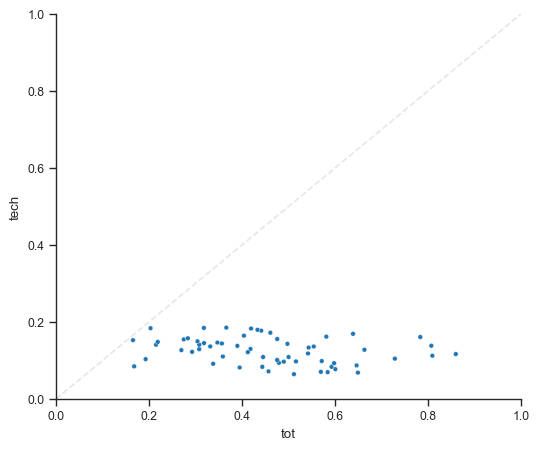

In [277]:
plotting.plot_colored_scatter_comparison(data=var_df, x='tot', y='tech', color_by_density=False, lim=[0,1])

#### original sigma

Better. Use in this case.

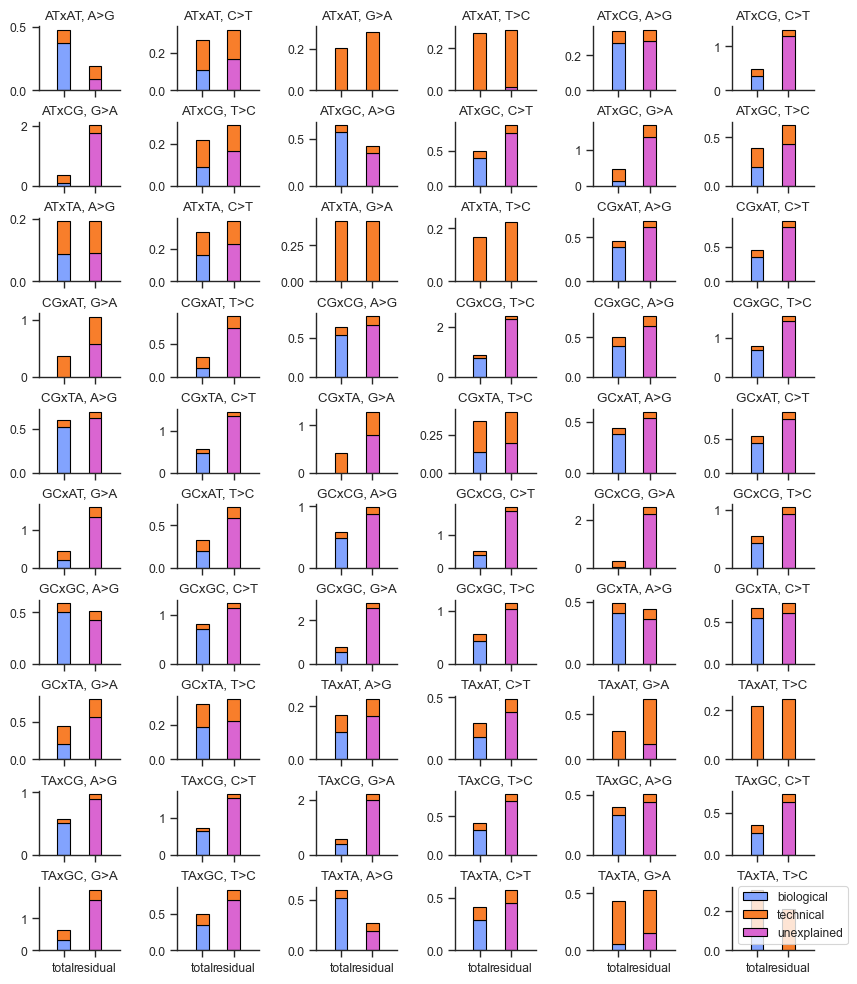

In [278]:
kwargs = dict(fill=True)
flanks, mismatches = np.unique(df.flank), np.unique(df.mismatch)

fig, ax = plt.subplots(10,6,figsize=(10,12), sharey=False, sharex=True)
ax = ax.flatten()

i = 0
var_df = pd.DataFrame(columns=var.keys())

for f in flanks:
    for m in mismatches:
        query = f'flank == "{f}" & mismatch == "{m}"'
        mm = f'{f}, {m}'
        tmp_df = df.query(query).reset_index()
        
        if len(tmp_df) > 10:           
            y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
            var = get_variances(y, sigma, y_hat, regress_sigma=False, verbose=False)
            tmp_df = pd.DataFrame(data=var, index=[mm])
            var_df = pd.concat([var_df, tmp_df])
            
            kwargs['ax'] = ax[i]
            ax[i].set_title(f'{f}, {m}')
            plot_variances(var, ax[i], label_text=False)
            i += 1
        
plt.legend()
plt.subplots_adjust(hspace=.5, wspace=.7)

util.save_fig('./fig/Fig3/mismatch/mm_variance_bar_grid_no_sigma_adjust.pdf')

##### bio & tot

In [438]:
var_df = var_df.query('tech < tot')
var_df['bio_score'] = var_df.bio / var_df.tot
var_df['uncaptured_score'] = var_df['?'] / var_df.bio
var_df['mismatch'] = [x.split(', ')[1] for x in var_df.index]

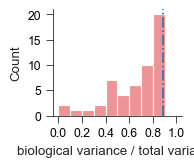

In [469]:
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
ax.tick_params(colors='k', width=.5)

sns.histplot(var_df.bio_score, bins=np.arange(0,1.1,.1), 
             color=np.array([234,112,117])/256)#, edgecolor=np.array([234,112,117])/256/1.5, linewidth=.5)
ax.xaxis.set_major_locator(MultipleLocator(.2))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.set_xlabel('biological variance / total variance')
plt.axvline(bio_score_all, linestyle='-.')
sns.despine()
util.save_fig('./fig/Fig3/mismatch/mm_variance_bio_over_tot.pdf')

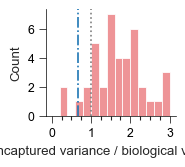

In [473]:
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
ax.tick_params(colors='k', width=.5)

sns.histplot(var_df.uncaptured_score, bins=np.arange(0,3.1,.2), 
             color=np.array([234,112,117])/256)#, edgecolor=np.array([234,112,117])/256/1.5, linewidth=.5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(.25))
ax.yaxis.set_major_locator(MultipleLocator(2))
plt.axvline(1, linestyle=':', color='gray')
plt.axvline(uncaptured_score_all, linestyle='-.')
ax.set_xlabel('uncaptured variance / biological variance')

sns.despine()
# util.save_fig('./fig/Fig3/mismatch/mm_variance_bio_over_tot.pdf')

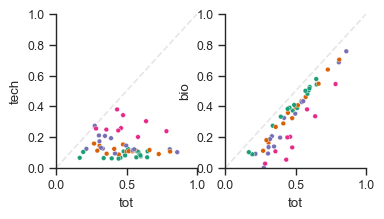

In [287]:
fig, ax = plt.subplots(1,2,figsize=(4,2))
plotting.plot_colored_scatter_comparison(data=var_df, x='tot', y='tech', color_by_density=False, lim=[0,1], ax=ax[0],
                                        hue='mismatch', palette='Dark2')
plotting.plot_colored_scatter_comparison(data=var_df, x='tot', y='bio', color_by_density=False, lim=[0,1], ax=ax[1],
                                         hue='mismatch', palette='Dark2')

In [347]:
palette = np.array([
    [131,164,255],
    [249,126,43],
    [219,101,210],
    [124,14,221],
    [148,94,234],
]) / 256.

(0.0, 1.0, 0.0, 1.0)

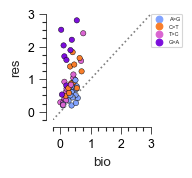

In [479]:
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, (ax, lax) = plt.subplots(1,2,figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[5,1]})
ax.tick_params(colors='k', width=.5)

lim=[-.25,3]
ax.plot(lim, lim, ':', c='gray')
sns.scatterplot(data=var_df, x='bio', y='res',  ax=ax, s=15, edgecolor='k',
                                         hue='mismatch', palette=palette)
ax.set_xlim(lim)
ax.set_ylim(lim)
sns.despine(offset=5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(.25))
ax.yaxis.set_minor_locator(MultipleLocator(.25))

ax.get_legend().remove()
h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4})
lax.axis("off")

# util.save_fig('./fig/Fig3/mismatch/mm_variance_bio_vs_tot.pdf')

## Centered mismatches

I tried to impute all enumerations here. Directly worked on dG instead of ddG and the result relies heavily on the WC pairs. Gave up on this version and switched to ddG without imputation.

In [3]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
annotation = pd.read_csv('./data/annotation/NNNlib2b_annotation_20220519.tsv', sep='\t',index_col=0)

df = arr.query('ConstructType == "Centered"')
df = df[[x[0] == 'G' for x in df.RefSeq]]

Everything's 18 nt long and the stack starts with a GC pair and ends with a CG pair (CGCG scaffold).

### ANOVA for each position

In [283]:
from scipy.spatial import distance

## Data organization ##
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df = arr.query('ConstructType == "Centered"')
df = df[[x[0] == 'G' for x in df.RefSeq]]

for i in range(6):
    p = i + 1 if i < 5 else 14
    df['p%d'%i] = [x[p] for x in df.RefSeq]

pos_cols = ['p%d'%i for i in range(6)]
anova_df = pd.DataFrame(index=range(4**6), columns=pos_cols)
for i,seq in enumerate(itertools.product('ATCG', repeat=6)):
    anova_df.iloc[i,:] = seq

anova_df = anova_df.merge(df[pos_cols+['dG_37']], left_on=pos_cols, right_on=pos_cols, how='left')

In [69]:
## dumb filling, assume it's sorted for similarity (biased to 3')
ffill = anova_df['dG_37'].fillna(method='ffill')
bfill = anova_df['dG_37'].fillna(method='bfill')

imputed_df = anova_df.copy()
imputed_df['dG_37'] = np.nanmean(pd.concat([ffill, bfill], axis=1), axis=1)

In [84]:
%%time
def hamming_distance(row1, row2):
    return distance.hamming(row1.values, row2.values)

def impute_with_hamming(ori_df, column_to_impute):
    # Find rows with missing values
    df = ori_df.copy()
    missing_rows = df[df[column_to_impute].isna()]
    print('#missing rows: ', len(missing_rows))
    complete_rows = df[~df[column_to_impute].isna()]
    complete_rows_feats = complete_rows.drop(column_to_impute, axis=1)
    
    for idx, missing_row in tqdm(missing_rows.iterrows()):

        # Compute distances to all other rows
        distances = complete_rows_feats.apply(lambda row: hamming_distance(missing_row.drop(column_to_impute), row), axis=1)
        
        # Find the index of the row with the smallest distance
        nearest_row_idx = distances.idxmin()

        # Impute the missing value
        df.at[idx, column_to_impute] = complete_rows.at[nearest_row_idx, column_to_impute]

    return df



imputed_df = impute_with_hamming(anova_df, 'dG_37')
print(imputed_df)



#missing rows:  1305


1305it [08:05,  2.69it/s]

     p0 p1 p2 p3 p4 p5     dG_37
0     A  A  A  A  A  A  0.845414
1     A  A  A  A  A  T  0.845414
2     A  A  A  A  A  C  0.845414
3     A  A  A  A  A  G  0.858242
4     A  A  A  A  T  A  0.674020
...  .. .. .. .. .. ..       ...
4091  G  G  G  G  C  G -2.546561
4092  G  G  G  G  G  A -2.074257
4093  G  G  G  G  G  T -1.946379
4094  G  G  G  G  G  C -0.938055
4095  G  G  G  G  G  G -1.578871

[4096 rows x 7 columns]
CPU times: user 8min, sys: 3.15 s, total: 8min 3s
Wall time: 8min 5s


In [85]:
imputed_df.to_csv('./data/models/processed/centered_mm_for_anova.csv')

In [120]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

total_variance = imputed_df['dG_37'].var()

contributions = []

for dimension in imputed_df.columns[:-1]:  # Assuming 'y' is the last column.
    formula = f'dG_37 ~ C({dimension})'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    between_group_variance = anova_table['sum_sq'][0]
    contribution = (between_group_variance / total_variance)# * 100
    contributions.append(contribution)


Interpreting color string as integer values


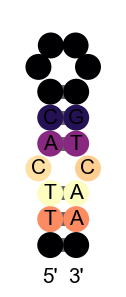

In [121]:
c = [0] + contributions[:5] + [0]*6 + contributions[3:5][::-1] + [contributions[5]] + contributions[:2][::-1] + [0]

draw_struct(row.RefSeq, '(((.(((....))).)))', c=c, cmap='magma')

In [123]:
anova_df.dropna(inplace=True)

total_variance = anova_df['dG_37'].var()

contributions = []

for dimension in anova_df.columns[:-1]:  # Assuming 'y' is the last column.
    formula = f'dG_37 ~ C({dimension})'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    between_group_variance = anova_table['sum_sq'][0]
    contribution = (between_group_variance / total_variance)# * 100
    contributions.append(contribution)


Interpreting color string as integer values


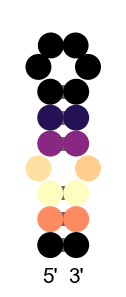

In [125]:
c = [0] + contributions[:5] + [0]*6 + contributions[3:5][::-1] + [contributions[5]] + contributions[:2][::-1] + [0]

draw_struct(' '*18, '(((.(((....))).)))', c=c, cmap='magma')

# 08/17/2023

## tetraloop

In [2]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df_nnn = arr.query('Series == "TETRAloop" & ConstructType == "NNN"')

annotation = pd.read_csv('./data/annotation/NNNlib2b_annotation_20220519.tsv', sep='\t',index_col=0)

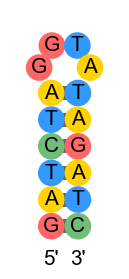

In [4]:
row = df_nnn.iloc[299,:]
seq, struct = row.RefSeq, row.TargetStruct
draw_struct(seq, struct)

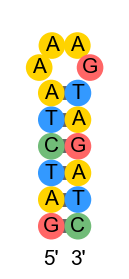

In [5]:
parent, loop = variance.find_hp_parent(seq, struct, annotation)
draw_struct(annotation.loc[parent, 'RefSeq'], annotation.loc[parent, 'TargetStruct'])

In [76]:
np.unique(arr.ConstructType)

array(['3mer', 'AC_mismatch_varpos', 'BaeControls', 'Centered',
       'GT_mismatch_varpos', 'NN', 'NNN', 'NNN_3primebulge',
       'NNN_5prime_bulge', 'NN_3primebulge', 'NN_5primebulge', 'VARloop',
       'WBcontrols', 'WC_5ntstem', 'WC_6ntstem', 'WC_7ntstem'],
      dtype=object)

In [78]:
annotation.query('ConstructType == "WC_6ntstem"')

,Series,ConstructType,bottomScaffold,topScaffold,RefSeq,dH_NUPACK,dS_NUPACK,Tm_NUPACK,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK
SEQID,,,,,,,,,,,,,
WC1,WatsonCrick,WC_6ntstem,GC,NaN,GAAAAAGAAATTTTTC,-43.6,-0.129292,64.070449,-3.817533,((((((....)))))),-3.50,-2.985250,-2.614174
WC4,WatsonCrick,WC_6ntstem,GC,NaN,GAAAATGAAAATTTTC,-42.1,-0.124843,64.074044,-3.679036,((((((....)))))),-3.38,-2.819953,-2.442225
WC7,WatsonCrick,WC_6ntstem,GC,NaN,GAAAAGGAAACTTTTC,-44.8,-0.130969,68.915977,-4.460032,((((((....)))))),-4.18,-3.579299,-3.187953
WC10,WatsonCrick,WC_6ntstem,GC,NaN,GAAAACGAAAGTTTTC,-46.5,-0.135934,68.927206,-4.616875,((((((....)))))),-4.34,-3.734476,-3.341796
WC13,WatsonCrick,WC_6ntstem,GC,NaN,GAAATAGAAATATTTC,-42.2,-0.126519,60.395617,-3.274672,((((((....)))))),-2.96,-2.434427,-2.070570
...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC3058,WatsonCrick,WC_6ntstem,GC,NaN,GCCCGCGAAAGCGGGC,-52.4,-0.140158,100.713814,-9.007319,((((((....)))))),-8.93,-7.850047,-7.402724
WC3061,WatsonCrick,WC_6ntstem,GC,NaN,GCCCCAGAAATGGGGC,-46.1,-0.124746,96.400659,-7.495362,((((((....)))))),-7.41,-6.341804,-5.896274
WC3064,WatsonCrick,WC_6ntstem,GC,NaN,GCCCCTGAAAAGGGGC,-44.6,-0.120458,97.104015,-7.328712,((((((....)))))),-7.24,-6.176443,-5.731568


In [83]:
[x for x in arr.query('ConstructType == "WC_6ntstem"').RefSeq if x.startswith('GAT')]

['GATAAAGAAATTTATC',
 'GATAATGAAAATTATC',
 'GATAAGGAAACTTATC',
 'GATAACGAAAGTTATC',
 'GATATAGAAATATATC',
 'GATATTGAAAAATATC',
 'GATATGGAAACATATC',
 'GATATCGAAAGATATC',
 'GATAGAGAAATCTATC',
 'GATAGTGAAAACTATC',
 'GATAGGGAAACCTATC',
 'GATAGCGAAAGCTATC',
 'GATACAGAAATGTATC',
 'GATACTGAAAAGTATC',
 'GATACGGAAACGTATC',
 'GATACCGAAAGGTATC',
 'GATTAAGAAATTAATC',
 'GATTATGAAAATAATC',
 'GATTAGGAAACTAATC',
 'GATTACGAAAGTAATC',
 'GATTTAGAAATAAATC',
 'GATTTTGAAAAAAATC',
 'GATTTGGAAACAAATC',
 'GATTTCGAAAGAAATC',
 'GATTGAGAAATCAATC',
 'GATTGTGAAAACAATC',
 'GATTGGGAAACCAATC',
 'GATTGCGAAAGCAATC',
 'GATTCAGAAATGAATC',
 'GATTCTGAAAAGAATC',
 'GATTCGGAAACGAATC',
 'GATTCCGAAAGGAATC',
 'GATGAAGAAATTCATC',
 'GATGATGAAAATCATC',
 'GATGAGGAAACTCATC',
 'GATGACGAAAGTCATC',
 'GATGTAGAAATACATC',
 'GATGTTGAAAAACATC',
 'GATGTGGAAACACATC',
 'GATGTCGAAAGACATC',
 'GATGGAGAAATCCATC',
 'GATGGTGAAAACCATC',
 'GATGGGGAAACCCATC',
 'GATGGCGAAAGCCATC',
 'GATGCAGAAATGCATC',
 'GATGCTGAAAAGCATC',
 'GATGCGGAAACGCATC',
 'GATGCCGAAAG

In [66]:
def get_parent_candidate(seq, struct):

    idxhp = (('('+struct).find('((..') + 1, (struct+')').find('..))') + 1)
    if idxhp[0] == 0 or idxhp[1] == 1:
        return None, None
    else:
        parent = seq[:idxhp[0]] + 'GAAA' + seq[idxhp[1]+1:]
        loop = seq[idxhp[0]:idxhp[1]+1]

        return parent, loop

In [68]:
parent_seq = get_parent_candidate(row.RefSeq, row.TargetStruct)[0]

In [71]:
parent_seq in annotation.RefSeq

False

In [6]:
df = df_nnn.copy()
n = len(df_nnn.TargetStruct.values[0])
df['parent'] = df.apply(lambda row: variance.find_hp_parent(row.RefSeq, row.TargetStruct, annotation), axis=1)

In [11]:
df = df_nnn.copy()
n = len(df_nnn.TargetStruct.values[0])
df['parent'] = df.apply(lambda row: variance.find_hp_parent(row.RefSeq, row.TargetStruct, arr), axis=1)

In [13]:
df['loop'] = df.parent.apply(lambda x: x[1])
df['parent'] = df.parent.apply(lambda x: x[0])

In [14]:
df

,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,dG_37_se,...,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected,parent,loop
SEQID,,,,,,,,,,,,,,,,,,,,,
TETNNN0,-15.950194,6.862576,-40.425869,-8.135955,23.055264,1.771083,20.330711,30.024373,0.737535,0.388900,...,-1.93,-1.891593,-1.580134,25.00,40.643772,-0.443578,-38.2,-0.116943,TETNNN3,AAAA
TETNNN1,-29.090211,2.652217,-38.761731,-21.755379,29.581855,0.601647,27.411949,31.393644,0.735006,0.076784,...,-3.33,-2.801608,-2.426313,25.00,48.278420,-1.578980,-45.0,-0.134354,TETNNN3,AAAT
TETNNN10,-32.627953,3.257442,-43.835289,-22.966019,34.949783,0.434112,33.716843,36.293001,0.268150,0.064912,...,-2.73,-2.324333,-1.969508,37.50,47.212789,-1.303844,-40.9,-0.123069,TETNNN3,AACC
TETNNN100,-43.585839,4.224275,-59.928228,-32.360885,40.276972,0.365588,39.492620,41.218584,-0.623644,0.062997,...,-3.21,-2.710645,-2.342172,31.25,48.063519,-1.549930,-45.0,-0.134741,TETNNN3,TCTA
TETNNN1000,-35.000029,7.668852,-58.343191,-20.895860,59.407063,1.180049,57.182891,62.213436,-2.436533,0.503145,...,-3.87,-3.289736,-2.903002,56.25,55.420452,-2.556446,-45.6,-0.134548,TETNNN771,GCCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TETNNN995,-39.078470,3.637699,-52.044689,-28.794428,54.677652,0.958070,51.853963,57.783780,-2.247098,0.154852,...,-3.77,-3.209396,-2.827118,56.25,56.117379,-2.519819,-43.4,-0.127777,TETNNN771,GCAG
TETNNN996,-30.997683,5.206059,-46.612579,-21.741415,60.530953,1.533912,57.952976,63.811062,-2.214493,0.343449,...,-3.87,-3.290291,-2.903906,50.00,54.718437,-2.464283,-45.6,-0.134548,TETNNN771,GCTA
TETNNN997,-43.230930,6.095441,-57.709753,-33.077025,47.503446,0.817547,46.082403,49.327983,-1.432802,0.137008,...,-3.67,-3.106962,-2.723854,50.00,54.747998,-2.338268,-43.2,-0.127454,TETNNN771,GCTT


In [15]:
hp_parents = np.unique([x for x in df.parent])
hp_parents

array(['TETNNN1027', 'TETNNN1283', 'TETNNN1539', 'TETNNN1795',
       'TETNNN2051', 'TETNNN2307', 'TETNNN2563', 'TETNNN259',
       'TETNNN2819', 'TETNNN3', 'TETNNN3075', 'TETNNN3331', 'TETNNN3587',
       'TETNNN3843', 'TETNNN515', 'TETNNN771'], dtype='<U10')

In [17]:
df = df.set_index('parent').join(arr[['dG_37', 'dG_37_se']], rsuffix='_parent').reset_index()

## add info ##

df['ddG_37'] = (df.dG_37 - df.dG_37_parent).astype(float)
df['ddG_37_se'] = (df.dG_37_se + df.dG_37_se_parent).astype(float)

In [88]:
np.unique([x[1] for x in df.parent])

array(['AAAA', 'AAAC', 'AAAG', 'AAAT', 'AACA', 'AACC', 'AACG', 'AACT',
       'AAGA', 'AAGC', 'AAGG', 'AAGT', 'AATA', 'AATC', 'AATG', 'AATT',
       'ACAA', 'ACAC', 'ACAG', 'ACAT', 'ACCA', 'ACCC', 'ACCG', 'ACCT',
       'ACGA', 'ACGC', 'ACGG', 'ACGT', 'ACTA', 'ACTC', 'ACTG', 'ACTT',
       'AGAA', 'AGAC', 'AGAG', 'AGAT', 'AGCA', 'AGCC', 'AGCG', 'AGCT',
       'AGGA', 'AGGC', 'AGGG', 'AGGT', 'AGTA', 'AGTC', 'AGTG', 'AGTT',
       'ATAA', 'ATAC', 'ATAG', 'ATAT', 'ATCA', 'ATCC', 'ATCG', 'ATCT',
       'ATGA', 'ATGC', 'ATGG', 'ATGT', 'ATTA', 'ATTC', 'ATTG', 'ATTT',
       'CAAA', 'CAAC', 'CAAG', 'CAAT', 'CACA', 'CACC', 'CACG', 'CACT',
       'CAGA', 'CAGC', 'CAGG', 'CAGT', 'CATA', 'CATC', 'CATG', 'CATT',
       'CCAA', 'CCAC', 'CCAG', 'CCAT', 'CCCA', 'CCCC', 'CCCG', 'CCCT',
       'CCGA', 'CCGC', 'CCGG', 'CCGT', 'CCTA', 'CCTC', 'CCTG', 'CCTT',
       'CGAA', 'CGAC', 'CGAG', 'CGAT', 'CGCA', 'CGCC', 'CGCG', 'CGCT',
       'CGGA', 'CGGC', 'CGGG', 'CGGT', 'CGTA', 'CGTC', 'CGTG', 'CGTT',
      

In [16]:
for p in hp_parents:
    print(p, p in arr.index)

TETNNN1027 True
TETNNN1283 True
TETNNN1539 True
TETNNN1795 True
TETNNN2051 True
TETNNN2307 True
TETNNN2563 True
TETNNN259 True
TETNNN2819 True
TETNNN3 True
TETNNN3075 True
TETNNN3331 True
TETNNN3587 True
TETNNN3843 True
TETNNN515 True
TETNNN771 True


In [20]:
anova_df = variance.get_pos_df(df, n=n, y_col='ddG_37')

In [22]:
contributions = dict()
for pos_col in anova_df.columns[:-1]:
    contributions[pos_col] = variance.get_sum_sq_explained(anova_df, pos_col, y_col='ddG_37')

In [23]:
contributions

{'p4': 15.976518833666358,
 'p5': 84.5121839041439,
 'p6': 221.06485116112998,
 'p7': 30.885628569982604,
 'p8': 45.418380291833785,
 'p9': 49.9146385688043,
 'p10': 84.51218390414256,
 'p11': 15.976518833669301}

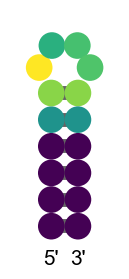

In [24]:
target_struct = df.TargetStruct.values[0]
c_log = np.zeros((len(np.unique(df['TargetStruct'])), n))
c = np.zeros(n)
for key,value in contributions.items():
    p = int(key.replace('p',''))
    c[p] = np.log(value)
c_log[0, :] = c

draw_struct(' '*n, target_struct, c=c, cmap='viridis')

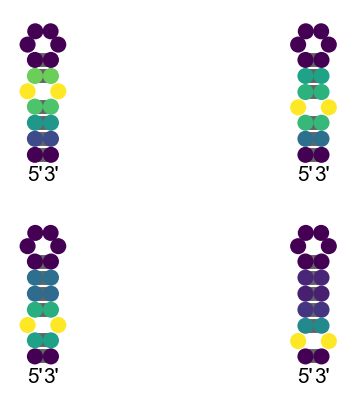

In [10]:
fig, ax = plt.subplots(2,2)
ax = ax.flatten()

df = df_nnn.copy()
n = len(df_nnn.TargetStruct.values[0])
c_log = np.zeros((len(np.unique(df['TargetStruct'])), n))

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    n = len(target_struct)
    tmp_df = df[df.TargetStruct == target_struct]
    anova_df = variance.get_pos_df(tmp_df, n=n)

    contributions = dict()
    for pos_col in anova_df.columns[:-1]:
        contributions[pos_col] = variance.get_sum_sq_explained(anova_df, pos_col, y_col='ddG_37')

    c = np.zeros(n)
    for key,value in contributions.items():
        p = int(key.replace('p',''))
        c[p] = np.log(value)
    c_log[ind, :] = c
    
    draw_struct(' '*n, target_struct, c=c, cmap='viridis', ax=ax[ind])
    
# util.save_fig('./fig/Fig3/importance/single_mm_importance.pdf')

# 08/22/2023

In [98]:
df = df_nnn.copy()
n = len(df_nnn.TargetStruct.values[0])

anova_df = variance.get_pos_df(df, n=n, y_col='dG_37')

contributions = dict()
for pos_col in anova_df.columns[:-1]:
    contributions[pos_col] = variance.get_sum_sq_explained(anova_df, pos_col, y_col='dG_37')

target_struct = df.TargetStruct.values[0]
c_log = np.zeros((len(np.unique(df['TargetStruct'])), n))
c = np.zeros(n)
for key,value in contributions.items():
    p = int(key.replace('p',''))
    c[p] = np.log(value)
c_log[0, :] = c

fig, ax = plt.subplots()

draw_struct(['%.1f'%x for x in c_log[0,:]], target_struct, c=c, cmap='viridis', ax=ax)

util.save_fig('./fig/Fig3/importance/tetraloop_variance_dG.pdf', fig=fig)

# 08/30/2023

In [1]:
import re

In [37]:
struct = '((((((....))))))'
pattern = '(\({1}[.]+\({1})|(\){1}[.]+\){1})'
match = re.search(pattern, struct)

start, end = match.span()

AttributeError: 'NoneType' object has no attribute 'span'

In [25]:
start

12

In [36]:
util.replace_at_index(struct, '', start+1, end-1)

'((((((....))))))'

In [31]:
np.isnan(2)

False

In [39]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df_nnn = arr.query('Series == "Bulges" & (ConstructType == "NNN_3primebulge" | ConstructType == "NNN_5prime_bulge")')

In [55]:
row = df_nnn.iloc[996,:]
seq, struct = row.RefSeq, row.TargetStruct
parent = variance.find_bg_parent(seq, struct, arr)
print(parent)

('WC610', 'TG')


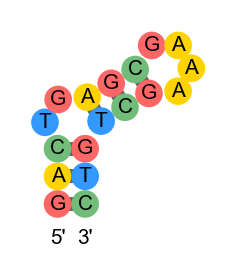

In [56]:
draw_struct(seq, struct)

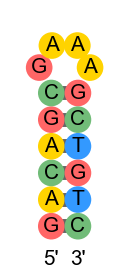

In [57]:
draw_struct(arr.loc[parent[0], 'RefSeq'], arr.loc[parent[0], 'TargetStruct'])

In [70]:
df = variance.find_bg_parent_df(df_nnn, arr).dropna()

['WC10' 'WC322' 'WC334' 'WC34' 'WC394' 'WC418' 'WC46' 'nan']


In [75]:
np.unique(df_nnn.TargetStruct)

array(['((((((....))).)))', '((((((....)))..)))', '(((.(((....))))))',
       '(((..(((....))))))'], dtype=object)

In [72]:
4**4

256

In [74]:
df_nnn

,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,dG_37_se,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
SEQID,,,,,,,,,,,,,,,,,,,,,
BNNN0,-15.247333,1.826325,-22.522935,-11.100944,27.838893,1.679771,23.158607,33.657065,0.462947,0.141768,...,-3.889374,(((.(((....)))))),-0.34,-3.434241,-3.081287,29.411765,27.915917,1.403048,-46.5,-0.148831
BNNN100,-11.563166,2.776991,-21.873465,-7.583820,23.976790,2.033664,19.368280,32.146591,0.477152,0.217036,...,-3.304332,(((.(((....)))))),-1.42,-3.091779,-2.862847,41.176471,35.772545,0.189926,-47.8,-0.149541
BNNN10000,-18.023523,2.646837,-27.475652,-12.582107,65.409967,2.359646,60.017544,72.952432,-1.483911,0.182677,...,-5.178260,(((.(((....)))))),-4.93,-4.265749,-3.904504,76.470588,60.997414,-3.763203,-52.4,-0.153055
BNNN10001,-20.290381,3.554113,-32.766841,-14.471566,65.839186,1.936920,60.814626,72.072200,-1.751886,0.262402,...,-5.190868,((((((....))).))),-4.93,-4.284203,-3.935632,76.470588,60.997414,-3.763203,-52.4,-0.153055
BNNN10002,-15.624815,1.547543,-21.140464,-12.072641,56.361378,1.836567,50.842117,62.258429,-0.933099,0.102187,...,-4.281984,(((..(((....)))))),-3.86,-3.670277,-3.382957,72.222222,59.880368,-2.871808,-41.8,-0.122328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BNNN9995,-14.850173,1.095143,-18.662069,-12.001824,51.115979,1.994635,44.359167,56.875760,-0.644036,0.075860,...,-5.008901,((((((....)))..))),-2.52,-4.269513,-3.922766,72.222222,49.394755,-1.560177,-40.6,-0.122779
BNNN9996,-30.726647,2.719387,-41.265616,-22.986414,48.700307,0.866914,46.044738,51.524247,-1.310439,0.078545,...,-4.884271,(((..(((....)))))),-2.52,-3.842596,-3.450312,66.666667,48.793256,-1.487238,-40.6,-0.122779
BNNN9997,-13.776267,2.315459,-19.139853,-10.410610,55.003081,12.762133,37.137937,82.540874,-0.768791,0.358067,...,-4.550493,((((((....)))..))),-2.52,-4.103215,-3.786116,66.666667,48.793256,-1.487238,-40.6,-0.122779


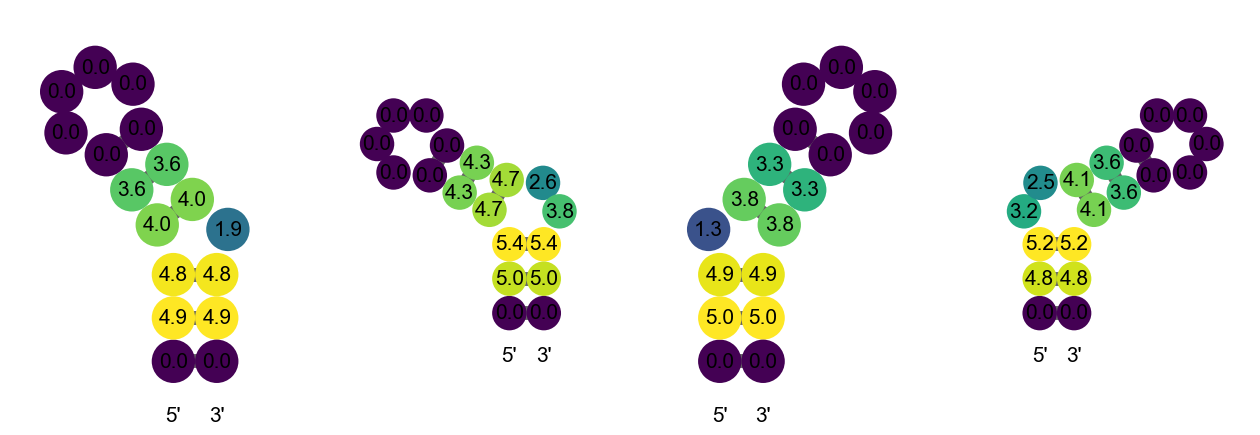

In [125]:
fig, ax = plt.subplots(1,4, figsize=(16,7))

for i,target_struct in enumerate(np.unique(df_nnn.TargetStruct)):
    contributions = variance.get_single_nt_contributions_df(df_nnn.query('TargetStruct == "%s"'%target_struct), y_col='dG_37')
    variance.plot_contributions_on_struct(contributions, target_struct, log_scale=True, ax=ax[i])
    
util.save_fig('./fig/Fig3/importance/bulge_importance.pdf')

0.031524165015885175
0.055869904953263605
0.03936997038029344
0.057072930705357794


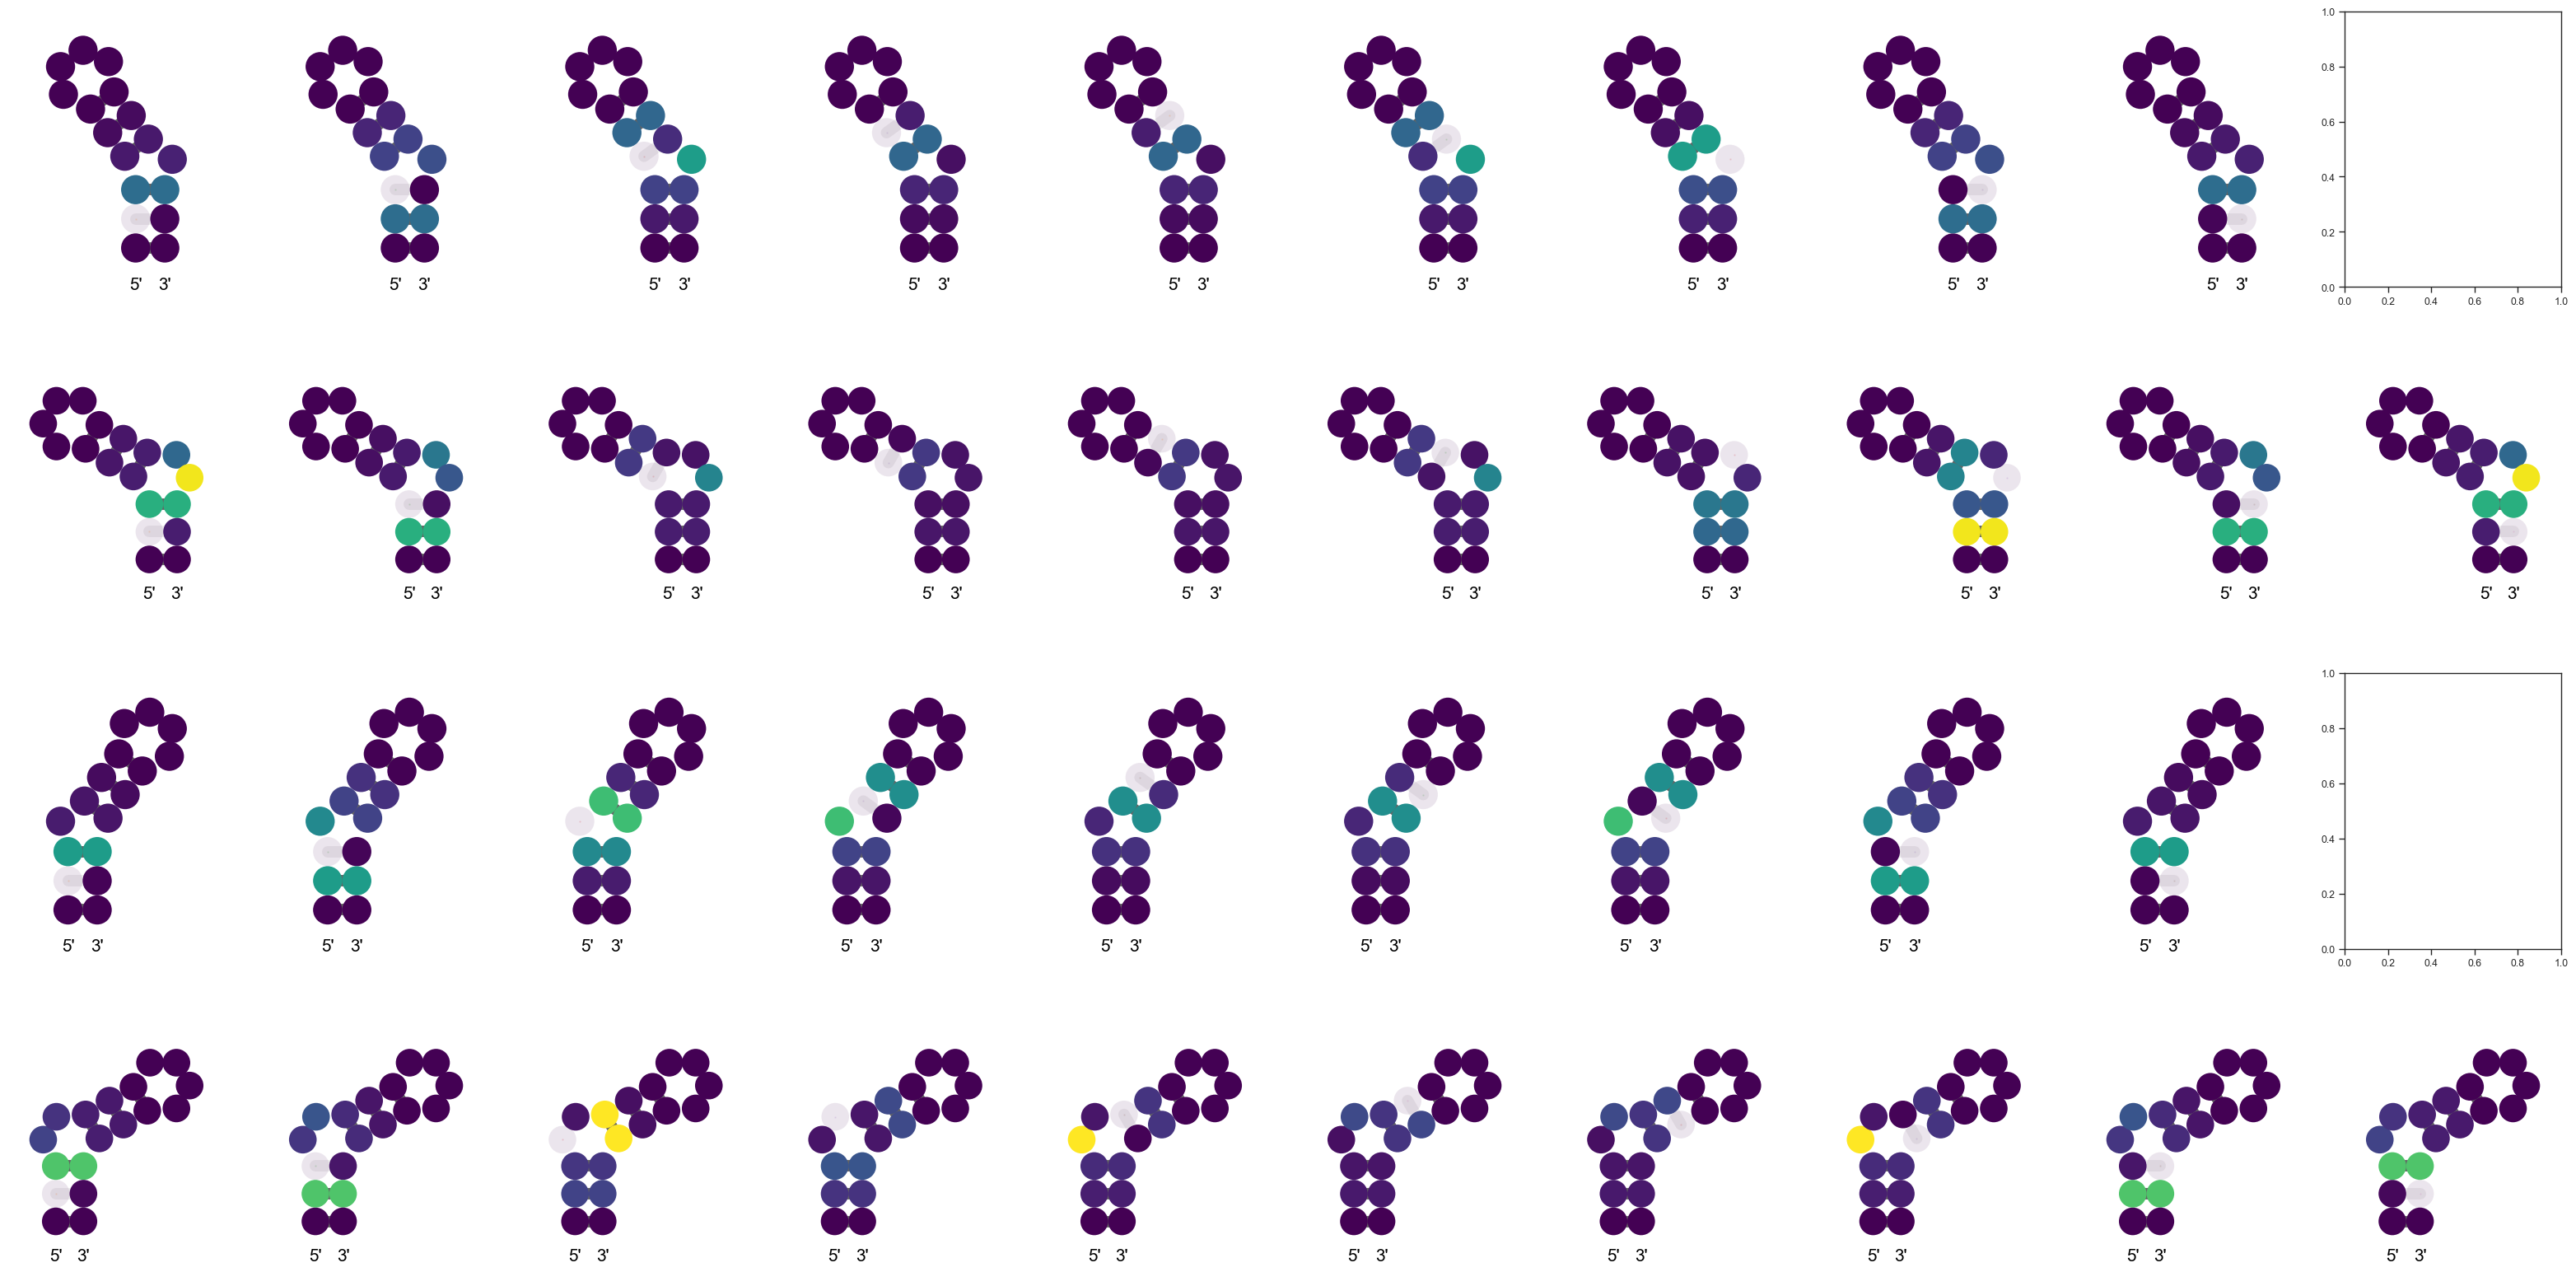

In [111]:
n_pair = 10
fig, ax = plt.subplots(4,n_pair, figsize=(40,20))
# ax = ax.flatten()

df = df_nnn.copy()
n = len(df['TargetStruct'].values[1])

contributions = dict()

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    n = len(target_struct)
    anova_df = variance.get_pos_df(tmp_df, n=n, y_col='dG_37')
    pos_cols = [c for c in anova_df.columns if c.startswith('p')]
    
    c_mat = np.zeros((n,n))
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col='dG_37')
        pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
        c_mat[int(pos1), int(pos2)] = v
        contributions[pair] = v

    c_mat_sym = c_mat + c_mat.T
    print(np.max(c_mat_sym.flatten()))
    k = 0
    for p in [int(x.replace('p','')) for x in pos_cols]:
        alpha = np.ones(n)
        alpha[p] = 0.1
        draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                    cmap='viridis', vmin=0, vmax=0.057,
                    ax=ax[ind, k])
        k += 1

util.save_fig('./fig/Fig3/importance/bulge_importance_pairwise.pdf')

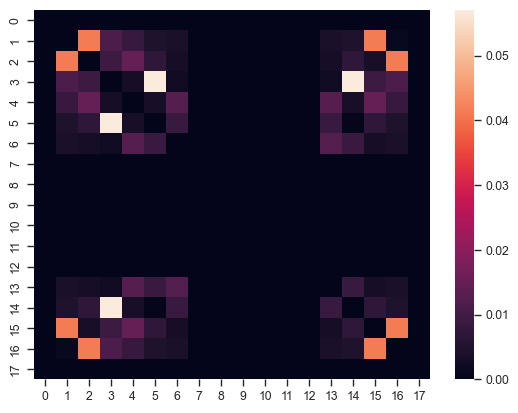

<Axes: >

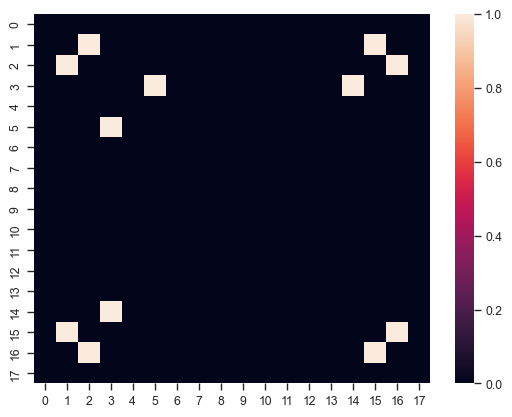

In [117]:
sns.heatmap(c_mat_sym)
plt.show()
sns.heatmap(c_mat_sym > 0.03)

<Axes: ylabel='Count'>

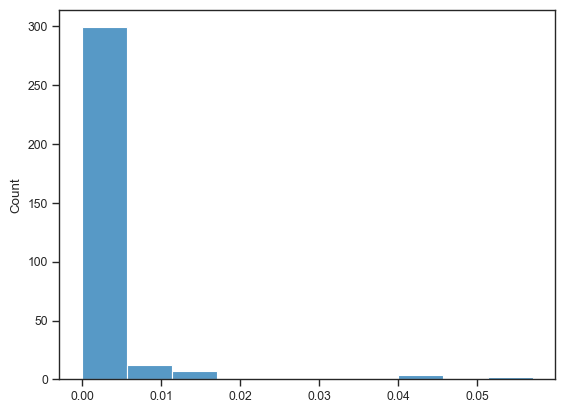

In [114]:
sns.histplot(c_mat.flatten())

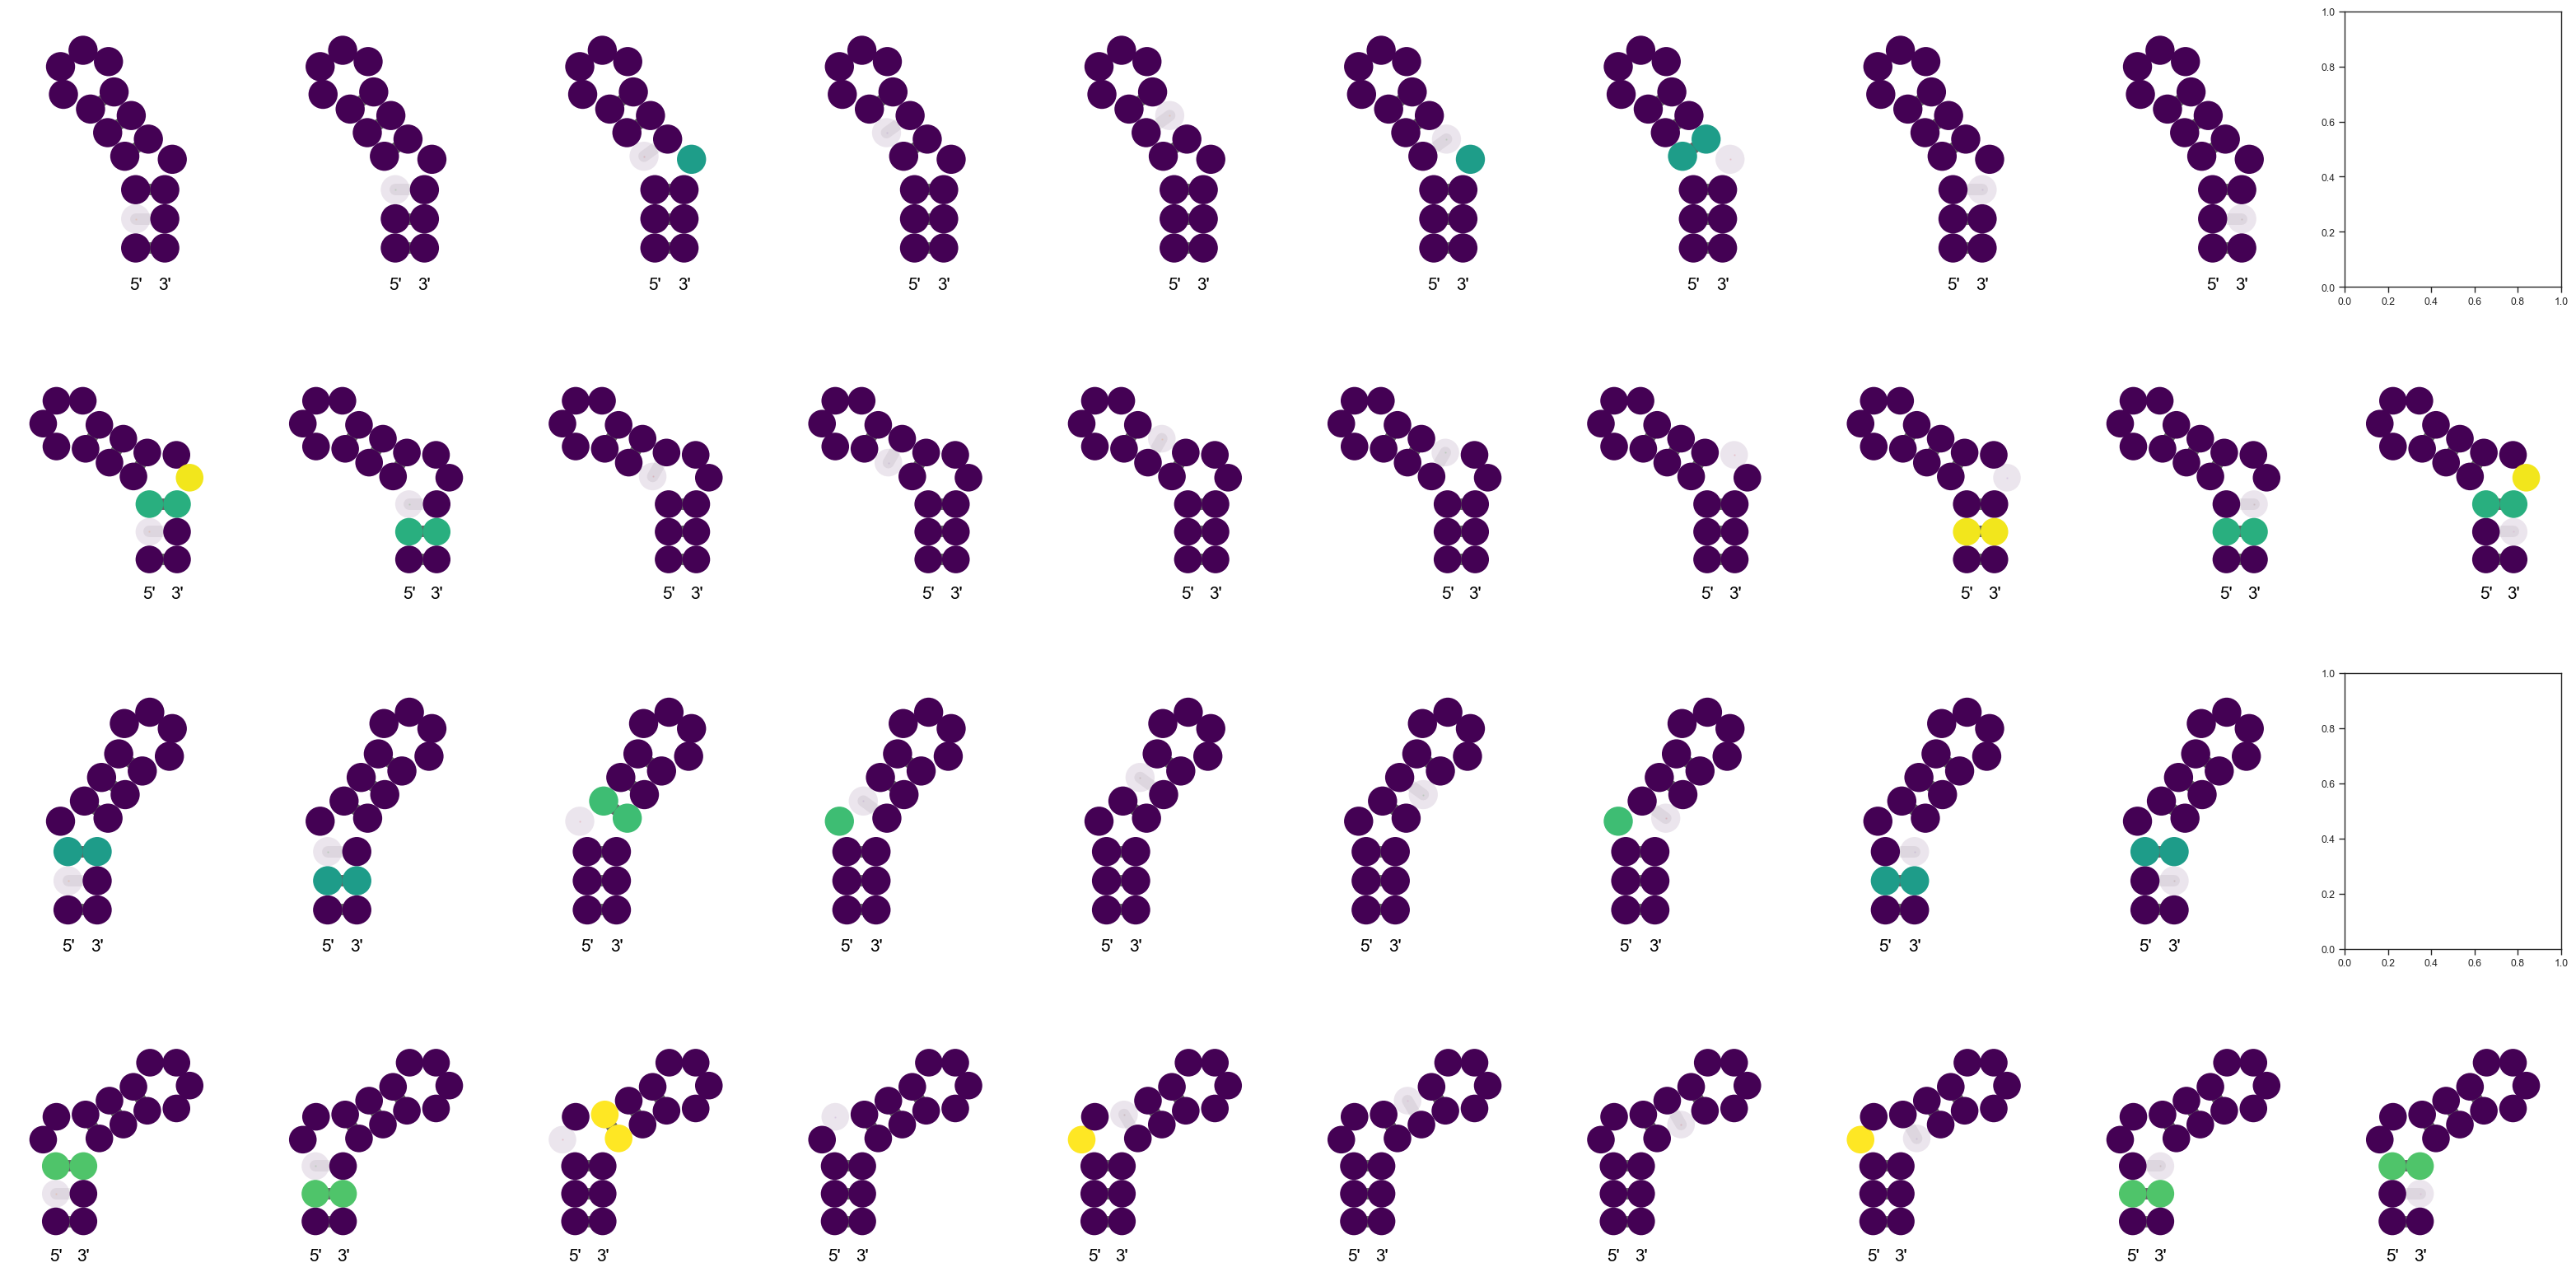

In [124]:
fig, ax = plt.subplots(4,n_pair, figsize=(40,20))

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    n = len(target_struct)
    anova_df = variance.get_pos_df(tmp_df, n=n, y_col='dG_37')
    pos_cols = [c for c in anova_df.columns if c.startswith('p')]
    
    c_mat = np.zeros((n,n))
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col='dG_37')
        pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
        c_mat[int(pos1), int(pos2)] = v
        contributions[pair] = v

    c_mat_sym = c_mat + c_mat.T
    # print(np.max(c_mat_sym.flatten()))
    c_mat_sym[c_mat_sym < 0.03] = 0
    k = 0
    for p in [int(x.replace('p','')) for x in pos_cols]:
        alpha = np.ones(n)
        alpha[p] = 0.1
        draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                    cmap='viridis', vmin=0, vmax=0.057,
                    ax=ax[ind, k])
        k += 1
        
util.save_fig('./fig/Fig3/importance/bulge_importance_pairwise_thresh.pdf')

# 08/31/2023

Analyze UV melt on the CD machine.